# Rossmann Store Sales Analysis
---

### *BDM capstone project Analysis notebook*

---

## Problem statements
1. **Store Performance Analytics & Segmentation**
    > Analyze sales, customer behavior, and store attributes to evaluate store performance and segment stores into high, medium, and low performers. Recommend strategies for improvement.
2. **Time-Series Pattern Analysis with Promotion & Holiday Impact**
    > Uncover seasonality and time-based patterns in sales while analyzing how promotions and holidays affect sales behavior.

##### Libraries used

In [1]:
# libraries used
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import Markdown



import warnings
warnings.filterwarnings(action='ignore')
sns.set(style="whitegrid")


### Data gathering and Descriptive statistics

In [2]:
# Note:- sales.csv is train.csv present in kaggle data, I changed it for better intuition.
# Gathering Data
if "sales.csv" not in os.listdir("../data/") or "store.csv" not in os.listdir("../data/"): 
    print("store and sales table required for analysis, aborting...")
    exit()

print("Data shape information:")   
store_data = pd.read_csv("../data/store.csv")
print("\tStore data have {} rows & {} columns".format(*store_data.shape))

sales_data = pd.read_csv("../data/sales.csv", low_memory=False)
print("\tSales data have {} rows & {} columns".format(*sales_data.shape))


Data shape information:
	Store data have 1115 rows & 10 columns
	Sales data have 1017209 rows & 9 columns


#### Store Data

In [3]:
# fields info and null count
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [4]:
# null values percentage
((store_data.isna().sum() / store_data.isna().count()) * 100).round(2)

Store                         0.00
StoreType                     0.00
Assortment                    0.00
CompetitionDistance           0.27
CompetitionOpenSinceMonth    31.75
CompetitionOpenSinceYear     31.75
Promo2                        0.00
Promo2SinceWeek              48.79
Promo2SinceYear              48.79
PromoInterval                48.79
dtype: float64

In [5]:
# descriptive statistics of numerical columns
store_data.describe().round(2)

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00,1112.00,761.00,761.00,1115.00,571.00,571.00
mean,558.00,5404.90,7.22,2008.67,0.51,23.60,2011.76
std,322.02,7663.17,3.21,6.20,0.50,14.14,1.67
min,1.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,279.50,717.50,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,2325.00,8.00,2010.00,1.00,22.00,2012.00
75%,836.50,6882.50,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,75860.00,12.00,2015.00,1.00,50.00,2015.00


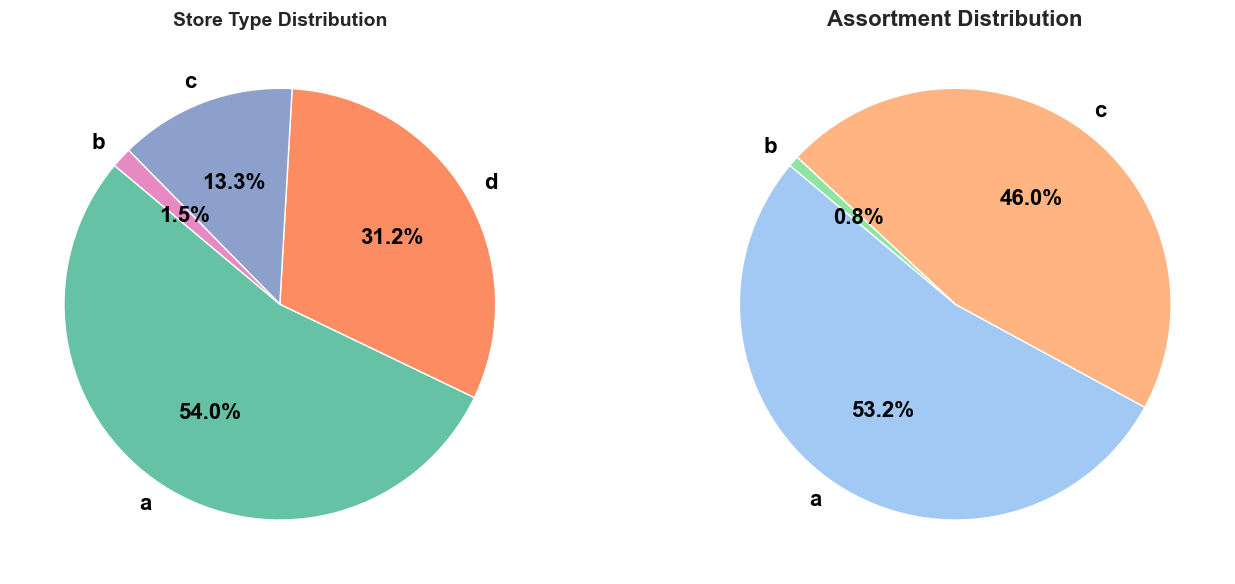

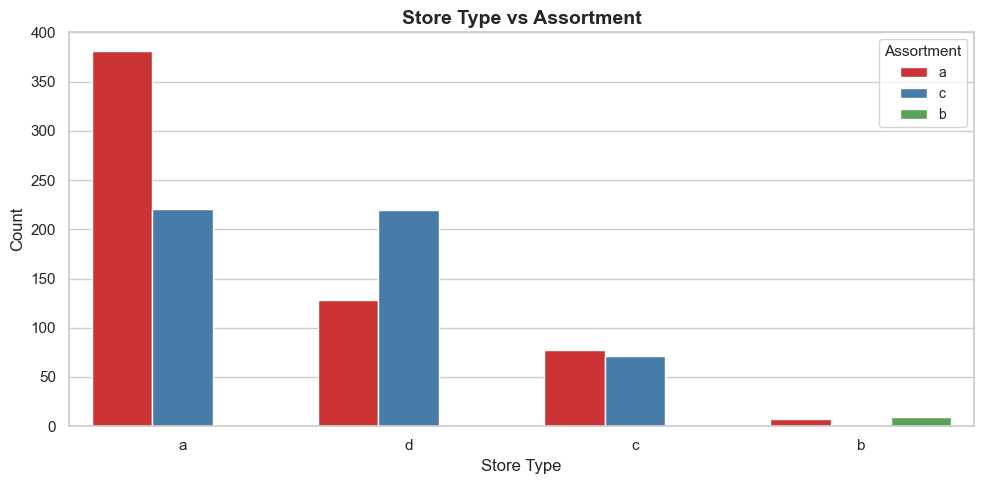

In [6]:
# descriptive statistics for categorical columns
# Pie charts for StoreType and Assortment Distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# StoreType Pie Chart
storetype_counts = store_data['StoreType'].value_counts()
ax[0].pie(
    storetype_counts, 
    labels=storetype_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('Set2'),
    wedgeprops=dict(edgecolor='w'),
    textprops={
        "fontsize": 16,
        "color": "#000000",
        "fontweight": "bold"
    }
)
ax[0].set_title("Store Type Distribution", fontsize=14, fontweight='bold')

# Assortment Pie Chart
assortment_counts = store_data['Assortment'].value_counts()
ax[1].pie(
    assortment_counts, 
    labels=assortment_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel'),
    wedgeprops=dict(edgecolor='w'),
    textprops={
        "fontsize": 16,
        "color": "#000000",
        "fontweight": "bold"
    }
)
ax[1].set_title("Assortment Distribution", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig("../charts/storetype_&_assortment_pie.png", dpi=300, bbox_inches='tight')
plt.show()

# StoreType vs Assortment
plt.figure(figsize=(10, 5))
sns.countplot(x='StoreType', hue='Assortment', data=store_data, palette='Set1', 
              order=store_data['StoreType'].value_counts().index,
              hue_order=store_data['Assortment'].value_counts().index)
plt.title("Store Type vs Assortment", fontsize=14, fontweight='bold')
plt.xlabel("Store Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='Assortment', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.savefig("../charts/storetype_vs_assortment.png", dpi=300, bbox_inches='tight')
plt.show()

#### Sales Data

In [7]:
# fields info and null count
sales_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31-07-2015,5263,555,1,1,0,1
1,2,5,31-07-2015,6064,625,1,1,0,1
2,3,5,31-07-2015,8314,821,1,1,0,1
3,4,5,31-07-2015,13995,1498,1,1,0,1
4,5,5,31-07-2015,4822,559,1,1,0,1


In [9]:
# null values percentage
((sales_data.isna().sum() / sales_data.isna().count()) * 100).round(2)

Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

In [10]:
# descriptive statistics of numerical columns
sales_data.describe().round(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.00,1017209.0,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,558.43,4.0,5773.82,633.15,0.83,0.38,0.18
std,321.91,2.0,3849.93,464.41,0.38,0.49,0.38
min,1.00,1.0,0.00,0.00,0.00,0.00,0.00
25%,280.00,2.0,3727.00,405.00,1.00,0.00,0.00
50%,558.00,4.0,5744.00,609.00,1.00,0.00,0.00
75%,838.00,6.0,7856.00,837.00,1.00,1.00,0.00
max,1115.00,7.0,41551.00,7388.00,1.00,1.00,1.00


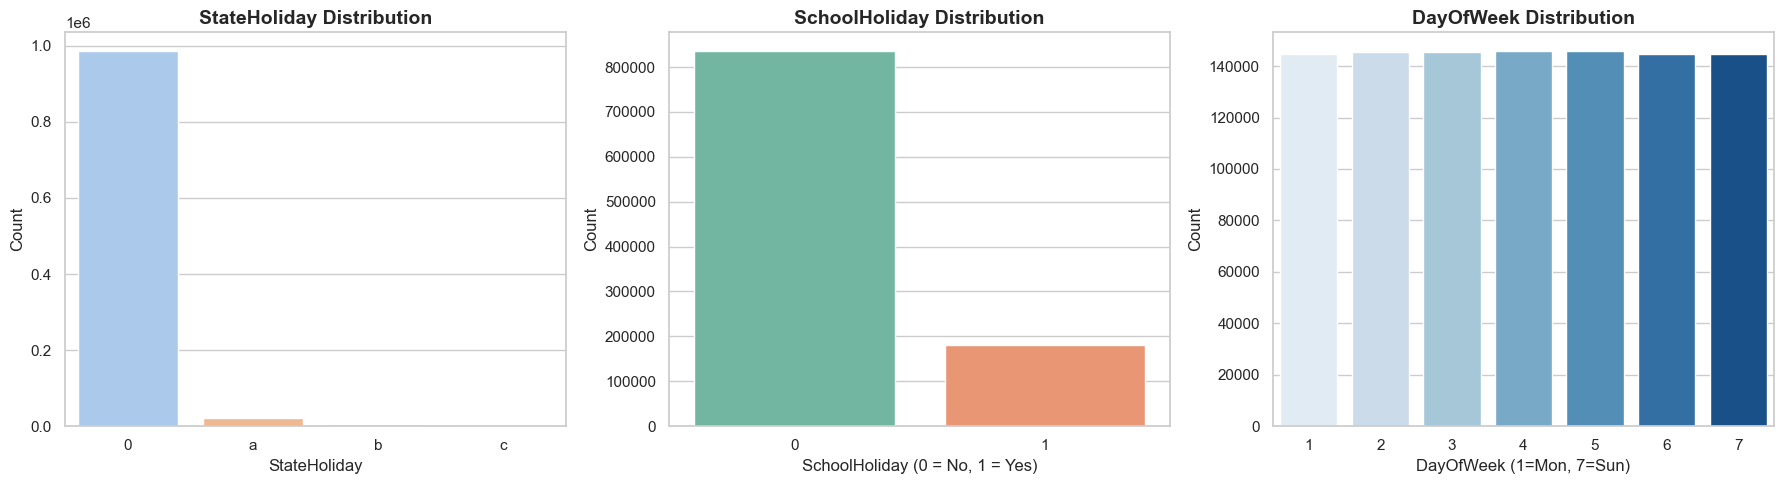

In [11]:
# Descriptive statistics charts for categorical variables in sales_data
plt.figure(figsize=(18, 5))

# 1. StateHoliday Distribution (Bar Chart)
plt.subplot(1, 3, 1)
state_counts = sales_data['StateHoliday'].value_counts()
sns.barplot(x=state_counts.index.astype(str), y=state_counts.values, palette='pastel')
plt.title("StateHoliday Distribution", fontsize=14, fontweight='bold')
plt.xlabel("StateHoliday")
plt.ylabel("Count")

# 2. SchoolHoliday Distribution (Bar Chart)
plt.subplot(1, 3, 2)
school_counts = sales_data['SchoolHoliday'].value_counts().sort_index()
sns.barplot(x=school_counts.index.astype(str), y=school_counts.values, palette='Set2')
plt.title("SchoolHoliday Distribution", fontsize=14, fontweight='bold')
plt.xlabel("SchoolHoliday (0 = No, 1 = Yes)")
plt.ylabel("Count")

# 3. DayOfWeek Distribution (Bar Chart)
plt.subplot(1, 3, 3)
dow_counts = sales_data['DayOfWeek'].value_counts().sort_index()
sns.barplot(x=dow_counts.index.astype(str), y=dow_counts.values, palette='Blues')
plt.title("DayOfWeek Distribution", fontsize=14, fontweight='bold')
plt.xlabel("DayOfWeek (1=Mon, 7=Sun)")
plt.ylabel("Count")

plt.tight_layout()
plt.savefig("../charts/sales_categorical_descriptive_stats.png", dpi=300, bbox_inches="tight")
plt.show()

### Data Cleaning and Preprocessing

In [12]:
df = sales_data.merge(store_data, on='Store', how='left')
df_open = df[df['Open'] == 1]
print(df.shape)
df.head().T

(1017209, 18)


,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,31-07-2015,31-07-2015,31-07-2015,31-07-2015,31-07-2015
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
StoreType,c,a,a,c,a


In [13]:
df.isna().sum() / df.shape[0] * 100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
dtype: float64

In [14]:
df['Date'] = pd.to_datetime(df['Date'])

# Filling missing CompetitionDistance with median
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)


# Filling missing CompetitionOpenSince
df['CompetitionOpenSinceMonth'].fillna(1, inplace=True)
df['CompetitionOpenSinceYear'].fillna(df['Date'].dt.year, inplace=True)

# Creating a datetime column for when competition began
df['CompetitionOpenDate'] = pd.to_datetime(dict(
    year=df['CompetitionOpenSinceYear'].astype(int),
    month=df['CompetitionOpenSinceMonth'].astype(int),
    day=1
))

# months since competition started
df['CompetitionMonthsActive'] = ((df['Date'] - df['CompetitionOpenDate']) / np.timedelta64(1, 'D') / 30).astype(int)
df['CompetitionMonthsActive'] = df['CompetitionMonthsActive'].apply(lambda x: max(x, 0))

# Handle Promo2 related nulls
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['PromoInterval'].fillna('', inplace=True)

# Promo2 start date
def get_promo2_start(row):
    if row['Promo2SinceYear'] > 0:
        return pd.to_datetime(f"{int(row['Promo2SinceYear'])}-W{int(row['Promo2SinceWeek']):02d}-1", format='%Y-W%W-%w')
    else:
        return pd.NaT

df['Promo2StartDate'] = df.apply(get_promo2_start, axis=1)

# Promo2 active flag
df['Promo2Active'] = 0
df.loc[(df['Promo2'] == 1) & (df['Date'] >= df['Promo2StartDate']), 'Promo2Active'] = 1

# check if the store is running promo in the current month
def is_promo_month(row):
    if row['PromoInterval']:
        promo_months = row['PromoInterval'].split(',')
        month_abbr = row['Date'].strftime('%b')
        return int(month_abbr in promo_months)
    return 0

df['IsPromoMonth'] = df.apply(is_promo_month, axis=1)

### Exloratory Data Analysis 

In [15]:
# data when shop is open
df_open = df[df['Open'] == 1]

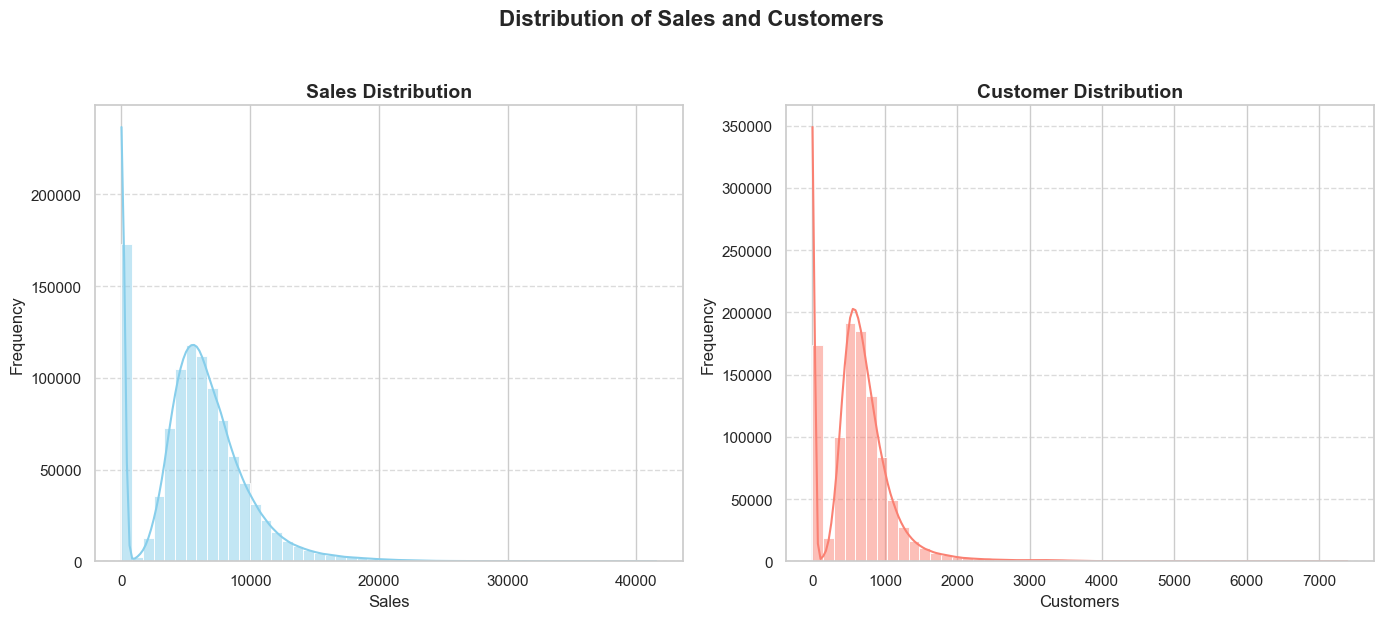

In [16]:
plt.figure(figsize=(14, 6))

# Sales Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['Sales'], kde=True, bins=50, color='skyblue')
plt.title('Sales Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customer Distribution
plt.subplot(1, 2, 2)
sns.histplot(df['Customers'], kde=True, bins=50, color='salmon')
plt.title('Customer Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Customers', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Distribution of Sales and Customers', fontsize=16, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig("../charts/sales_customers_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


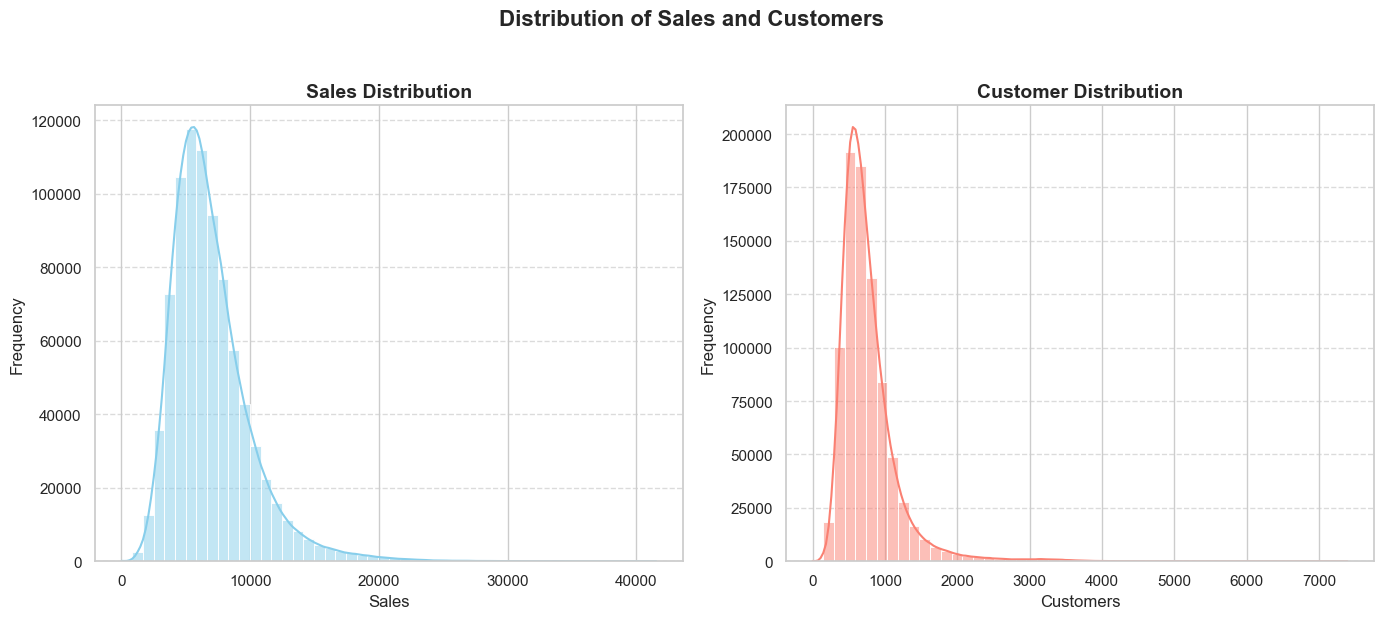

In [17]:
plt.figure(figsize=(14, 6))

# Sales Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_open['Sales'], kde=True, bins=50, color='skyblue')
plt.title('Sales Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customer Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_open['Customers'], kde=True, bins=50, color='salmon')
plt.title('Customer Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Customers', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Distribution of Sales and Customers', fontsize=16, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig("../charts/sales_customers_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


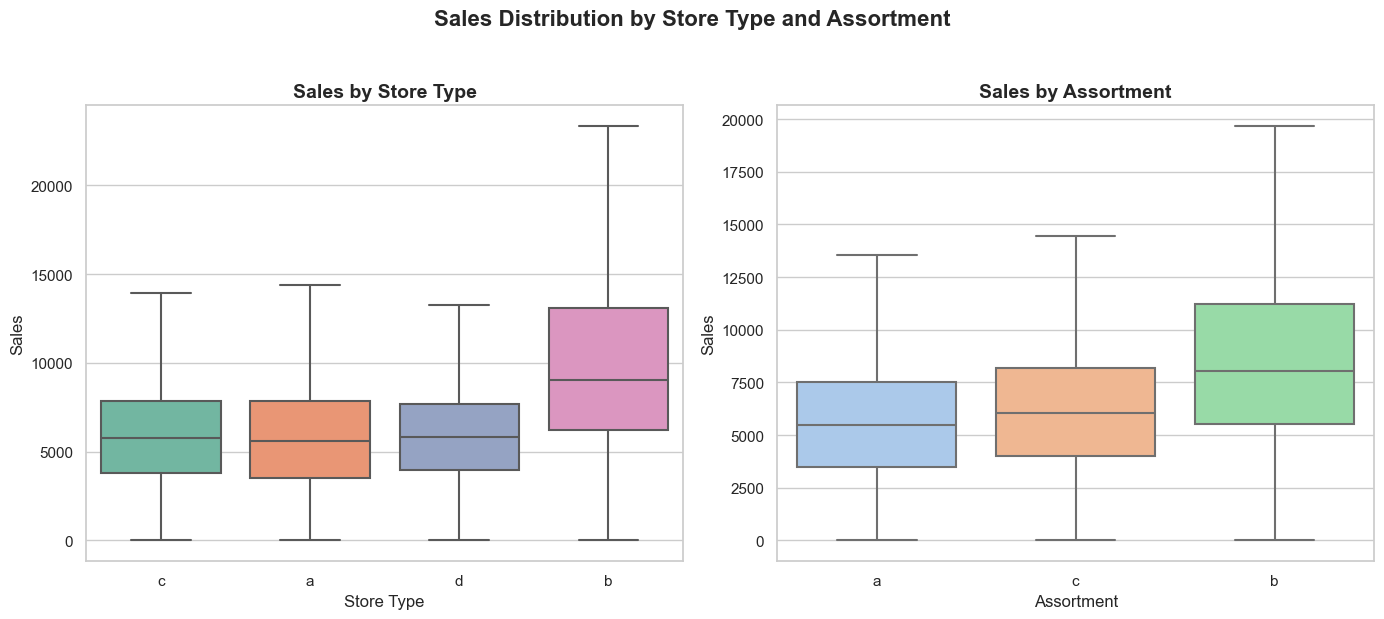

In [18]:
plt.figure(figsize=(14, 6))

# Sales vs StoreType
plt.subplot(1, 2, 1)
sns.boxplot(
    x='StoreType', y='Sales', data=df,
    palette='Set2', showfliers=False, linewidth=1.5
)
plt.title('Sales by Store Type', fontsize=14, fontweight='bold')
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Sales', fontsize=12)

# Sales vs Assortment
plt.subplot(1, 2, 2)
sns.boxplot(
    x='Assortment', y='Sales', data=df,
    palette='pastel', showfliers=False, linewidth=1.5
)
plt.title('Sales by Assortment', fontsize=14, fontweight='bold')
plt.xlabel('Assortment', fontsize=12)
plt.ylabel('Sales', fontsize=12)

plt.suptitle('Sales Distribution by Store Type and Assortment', fontsize=16, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig("../charts/sales_by_storetype_assortment.png", dpi=300, bbox_inches='tight')
plt.show()


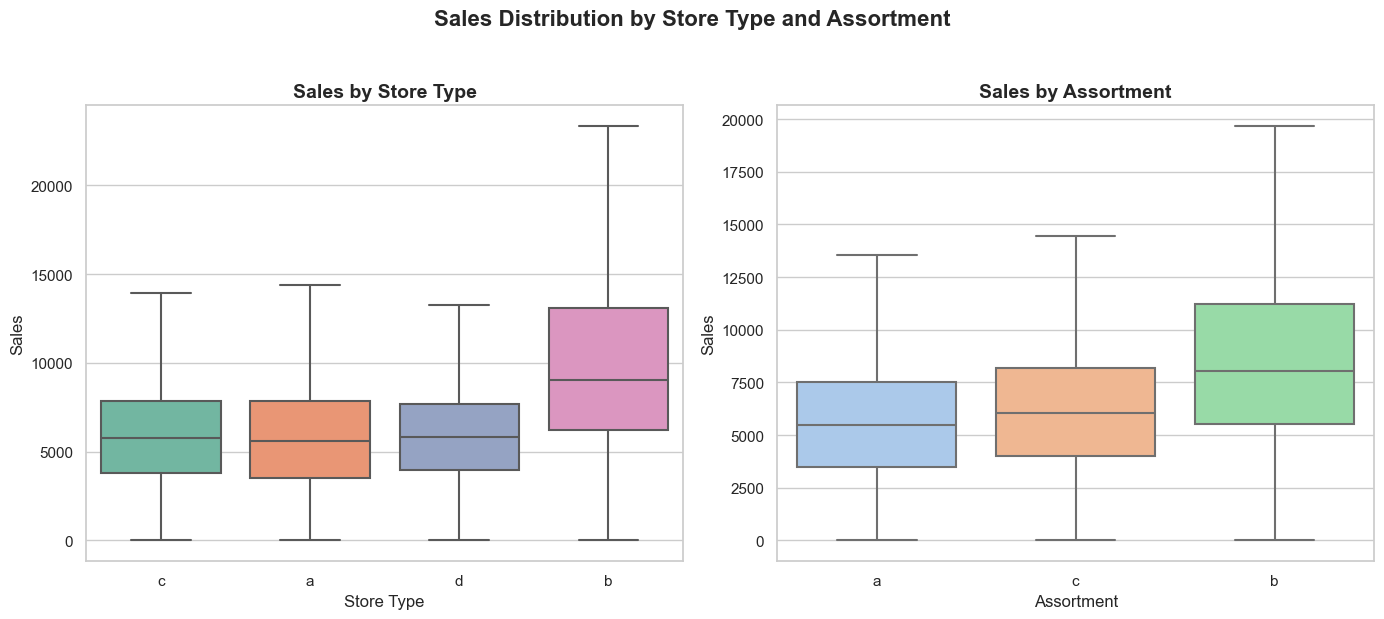

In [19]:
plt.figure(figsize=(14, 6))

# Sales vs StoreType
plt.subplot(1, 2, 1)
sns.boxplot(
    x='StoreType', y='Sales', data=df,
    palette='Set2', showfliers=False, linewidth=1.5
)
plt.title('Sales by Store Type', fontsize=14, fontweight='bold')
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Sales', fontsize=12)

# Sales vs Assortment
plt.subplot(1, 2, 2)
sns.boxplot(
    x='Assortment', y='Sales', data=df,
    palette='pastel', showfliers=False, linewidth=1.5
)
plt.title('Sales by Assortment', fontsize=14, fontweight='bold')
plt.xlabel('Assortment', fontsize=12)
plt.ylabel('Sales', fontsize=12)

plt.suptitle('Sales Distribution by Store Type and Assortment', fontsize=16, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig("../charts/sales_by_storetype_assortment.png", dpi=300, bbox_inches='tight')
plt.show()


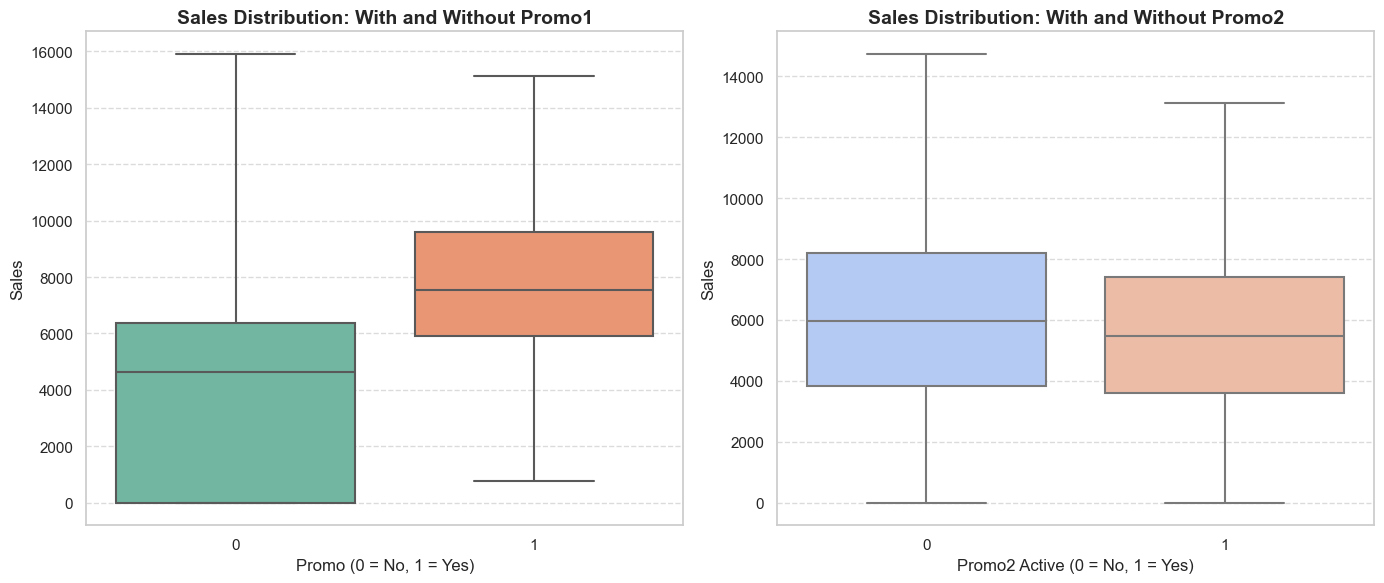

In [20]:
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
sns.boxplot(
    x='Promo',
    y='Sales',
    data=df,
    palette='Set2',
    showfliers=False,
    linewidth=1.5,

)
plt.title('Sales Distribution: With and Without Promo1', fontsize=14, fontweight='bold')
plt.xlabel('Promo (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.subplot(1, 2, 2)
sns.boxplot(
    x='Promo2Active',
    y='Sales',
    data=df,
    palette='coolwarm',
    showfliers=False,
    linewidth=1.5
)
plt.title('Sales Distribution: With and Without Promo2', fontsize=14, fontweight='bold')
plt.xlabel('Promo2 Active (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../charts/sales_with_without_promo.png", dpi=300, bbox_inches='tight')
plt.show()


In [21]:
top_sales = df[df['Sales'] > df['Sales'].quantile(0.99)]
print(top_sales[['Store', 'Sales', 'Customers']].sort_values(by='Sales', ascending=False).head())

        Store  Sales  Customers
44393     909  41551       1721
132946    262  38722       5132
101726    262  38484       5458
87231     262  38367       5192
424086     57  38037       1970


In [22]:
top_sales = df[df['Sales'] < df['Sales'].quantile(0.2)]
print(top_sales[['Store', 'Sales', 'Customers']].sort_values(by='Sales', ascending=True).head())

         Store  Sales  Customers
1017201   1108      0          0
1017178   1085      0          0
1017179   1086      0          0
1017180   1087      0          0
1017181   1088      0          0


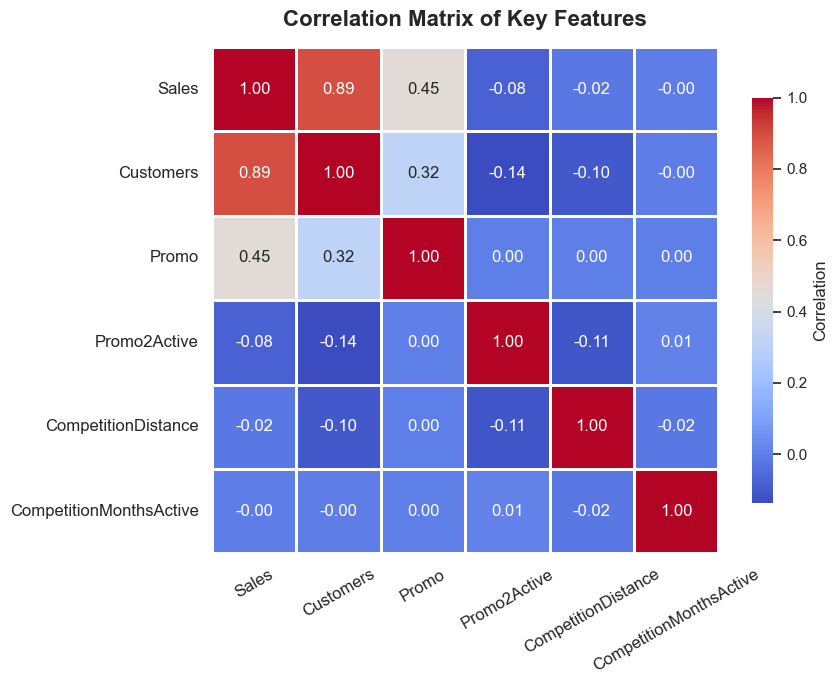

In [23]:
# Select relevant numeric features
corr_cols = ['Sales', 'Customers', 'Promo', 'Promo2Active', 'CompetitionDistance', 'CompetitionMonthsActive']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=2,
    linecolor='white',
    square=True,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'}
)
plt.title('Correlation Matrix of Key Features', fontsize=16, fontweight='bold', pad=15)
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.savefig("../charts/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


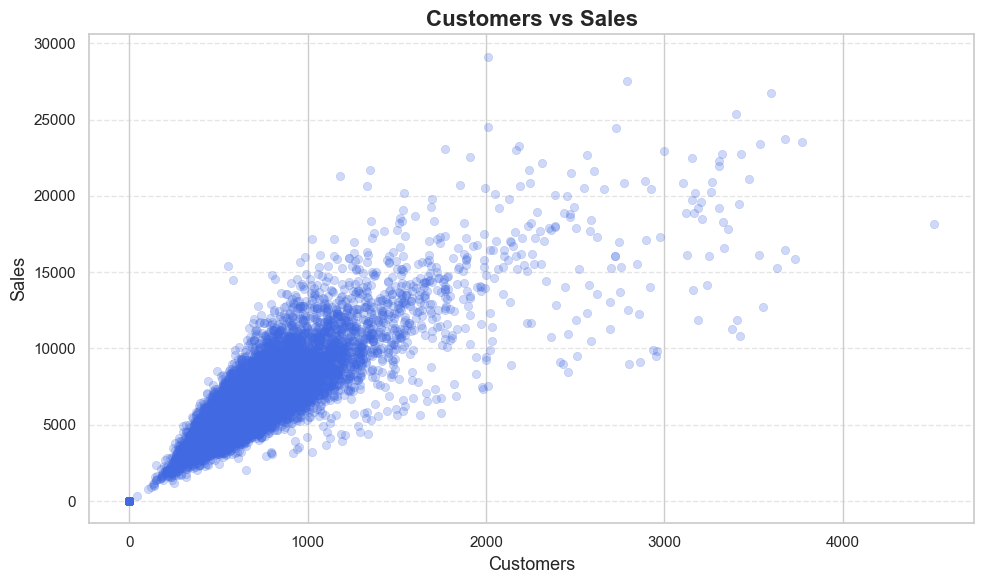

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Customers',
    y='Sales',
    data=df.sample(10000, random_state=42),
    alpha=0.25,
    edgecolor=None,
    color='royalblue'
)
plt.title('Customers vs Sales', fontsize=16, fontweight='bold')
plt.xlabel('Customers', fontsize=13)
plt.ylabel('Sales', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../charts/customers_vs_sales.png", dpi=300, bbox_inches='tight')
plt.show()


### Feature Engineering

In [25]:
# Filter only open days for meaningful averages
df_open = df[df['Open'] == 1]

# Group by store to calculate store-level performance metrics
store_agg = df_open.groupby('Store').agg(
    AvgSalesPerDay=('Sales', 'mean'),
    AvgCustomersPerDay=('Customers', 'mean'),
    OpenDays=('Date', 'count'),
    PromoDays=('Promo', 'sum'),
    Promo2Days=('Promo2Active', 'sum'),
    CompetitionDistance=('CompetitionDistance', 'first'),
    CompetitionMonthsActive=('CompetitionMonthsActive', 'first'),
    StoreType=('StoreType', 'first'),
    Assortment=('Assortment', 'first')
).reset_index()

# Ratios
store_agg['PromoDaysRatio'] = store_agg['PromoDays'] / store_agg['OpenDays']
store_agg['Promo2DaysRatio'] = store_agg['Promo2Days'] / store_agg['OpenDays']

# Drop columns used in ratios to reduce redundancy
store_agg.drop(columns=['OpenDays', 'PromoDays', 'Promo2Days'], inplace=True)
print(store_agg.describe().round(2))


# One-hot encode categorical columns
store_encoded = pd.get_dummies(store_agg, columns=['StoreType', 'Assortment'], drop_first=True)


# Normalize the numerical features for clustering
numeric_cols = [
    'AvgSalesPerDay', 'AvgCustomersPerDay', 'PromoDaysRatio',
    'Promo2DaysRatio', 'CompetitionDistance', 'CompetitionMonthsActive'
]

scaler = StandardScaler()
store_encoded[numeric_cols] = scaler.fit_transform(store_encoded[numeric_cols])

# store_encoded is ready for clustering
# store_encoded.head()

         Store  AvgSalesPerDay  AvgCustomersPerDay  CompetitionDistance  \
count  1115.00         1115.00             1115.00              1115.00   
mean    558.00         6934.21              754.51              5396.63   
std     322.02         2383.91              353.34              7654.51   
min       1.00         2703.74              240.18                20.00   
25%     279.50         5322.30              541.47               720.00   
50%     558.00         6589.95              678.67              2330.00   
75%     836.50         7964.20              866.20              6875.00   
max    1115.00        21757.48             3403.46             75860.00   

       CompetitionMonthsActive  PromoDaysRatio  Promo2DaysRatio  
count                  1115.00         1115.00          1115.00  
mean                     55.04            0.45             0.44  
std                      70.30            0.01             0.46  
min                       0.00            0.38             0

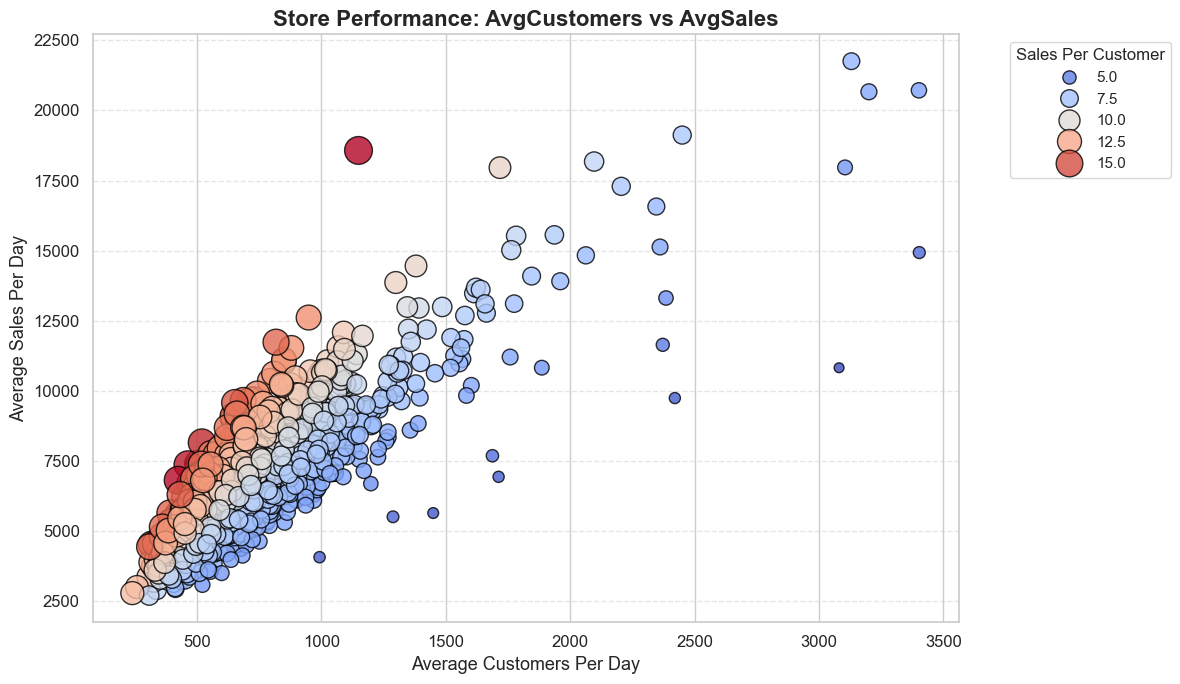

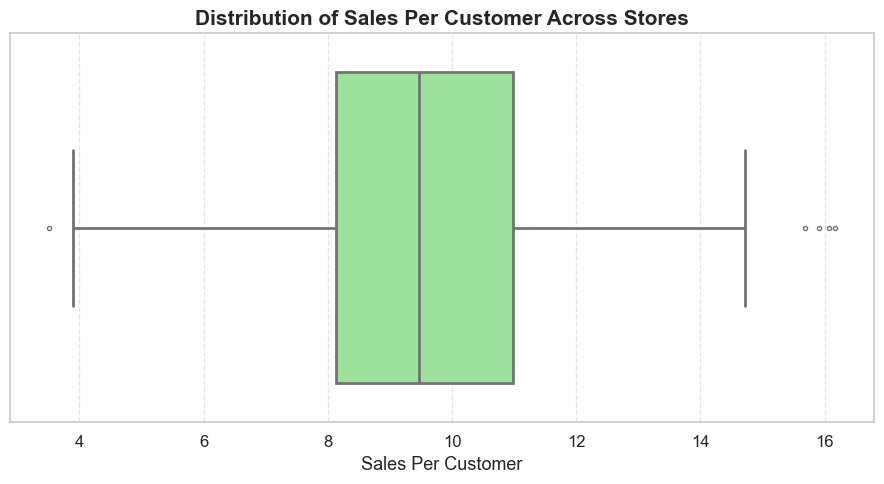

In [26]:
store_perf = df_open.groupby('Store').agg(
    AvgSales=('Sales', 'mean'),
    AvgCustomers=('Customers', 'mean')
).reset_index()

store_perf['SalesPerCustomer'] = store_perf['AvgSales'] / store_perf['AvgCustomers']

# Scatter Plot - AvgCustomers vs AvgSales (bubble = SalesPerCustomer)
plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(
    data=store_perf,
    x='AvgCustomers',
    y='AvgSales',
    size='SalesPerCustomer',
    hue='SalesPerCustomer',
    palette='coolwarm',
    sizes=(50, 400),
    alpha=0.8,
    edgecolor='black',
    legend='brief'
)
plt.title('Store Performance: AvgCustomers vs AvgSales', fontsize=16, fontweight='bold')
plt.xlabel('Average Customers Per Day', fontsize=13)
plt.ylabel('Average Sales Per Day', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Sales Per Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../charts/store_perf_scatter_avgcust_avgsales.png", dpi=300, bbox_inches='tight')
plt.show()

# Boxplot - SalesPerCustomer Distribution
plt.figure(figsize=(9, 5))
sns.boxplot(
    x=store_perf['SalesPerCustomer'],
    color='lightgreen',
    linewidth=2,
    fliersize=3
)
plt.title('Distribution of Sales Per Customer Across Stores', fontsize=15, fontweight='bold')
plt.xlabel('Sales Per Customer', fontsize=13)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig("../charts/sales_per_customer_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

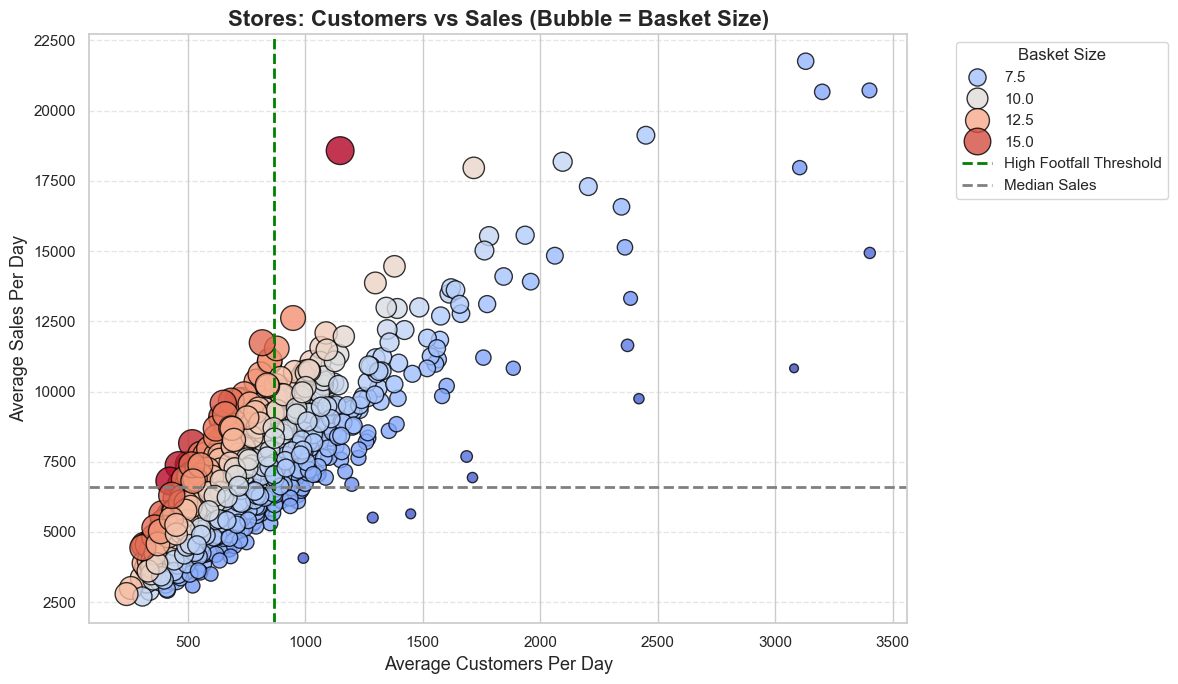


### Customers vs Sales (Bubble = Basket Size)

- **Total Stores Analyzed:** 1115
- **High Footfall Threshold (75th percentile of AvgCustomers):** 866.2
- **Low Basket Value Threshold (25th percentile of SalesPerCustomer):** 8.13
- **Median AvgSalesPerDay (used for reference line):** 6589.95

#### Insight:
- **151 stores** have **high customer traffic but low basket value**.
- Store with the **lowest SalesPerCustomer**:  
  - **Store ID:** 769  
  - **Type:** b, **Assortment:** b  
  - **AvgCustomers/Day:** 3081.05,  
    **AvgSales/Day:** 10825.9,  
    **SalesPerCustomer:** 3.51


In [27]:
store_perf = df_open.groupby('Store').agg(
    AvgSalesPerDay=('Sales', 'mean'),
    AvgCustomersPerDay=('Customers', 'mean')
).reset_index()

# basket size
store_perf['SalesPerCustomer'] = store_perf['AvgSalesPerDay'] / store_perf['AvgCustomersPerDay']

cust_thresh = store_perf['AvgCustomersPerDay'].quantile(0.75)
basket_thresh = store_perf['SalesPerCustomer'].quantile(0.25)

high_footfall_low_sales = store_perf[
    (store_perf['AvgCustomersPerDay'] >= cust_thresh) &
    (store_perf['SalesPerCustomer'] <= basket_thresh)
]

store_meta = df[['Store', 'StoreType', 'Assortment']].drop_duplicates()
result = high_footfall_low_sales.merge(store_meta, on='Store', how='left')


plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(
    x='AvgCustomersPerDay',
    y='AvgSalesPerDay',
    size='SalesPerCustomer',
    hue='SalesPerCustomer',
    data=store_perf,
    palette='coolwarm',
    sizes=(40, 400),
    alpha=0.8,
    edgecolor='black',
    legend='brief'
)

plt.axvline(cust_thresh, color='green', linestyle='--', linewidth=2, label='High Footfall Threshold')
plt.axhline(store_perf['AvgSalesPerDay'].median(), color='gray', linestyle='--', linewidth=2, label='Median Sales')

plt.title('Stores: Customers vs Sales (Bubble = Basket Size)', fontsize=16, fontweight='bold')
plt.xlabel('Average Customers Per Day', fontsize=13)
plt.ylabel('Average Sales Per Day', fontsize=13)

# legend enhancement
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], title='Basket Size', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../charts/high_footfall_low_basket_scatter.png", dpi=300, bbox_inches='tight')
plt.show()



# chart summary
total_stores = store_perf.shape[0]
cust_thresh_val = round(cust_thresh, 2)
basket_thresh_val = round(basket_thresh, 2)
median_sales = round(store_perf['AvgSalesPerDay'].median(), 2)

high_low_count = high_footfall_low_sales.shape[0]
lowest = result.sort_values(by='SalesPerCustomer').iloc[0]

summary = f"""
### Customers vs Sales (Bubble = Basket Size)

- **Total Stores Analyzed:** {total_stores}
- **High Footfall Threshold (75th percentile of AvgCustomers):** {cust_thresh_val}
- **Low Basket Value Threshold (25th percentile of SalesPerCustomer):** {basket_thresh_val}
- **Median AvgSalesPerDay (used for reference line):** {median_sales}

#### Insight:
- **{high_low_count} stores** have **high customer traffic but low basket value**.
- Store with the **lowest SalesPerCustomer**:  
  - **Store ID:** {int(lowest['Store'])}  
  - **Type:** {lowest['StoreType']}, **Assortment:** {lowest['Assortment']}  
  - **AvgCustomers/Day:** {round(lowest['AvgCustomersPerDay'], 2)},  
    **AvgSales/Day:** {round(lowest['AvgSalesPerDay'], 2)},  
    **SalesPerCustomer:** {round(lowest['SalesPerCustomer'], 2)}
"""

Markdown(summary)


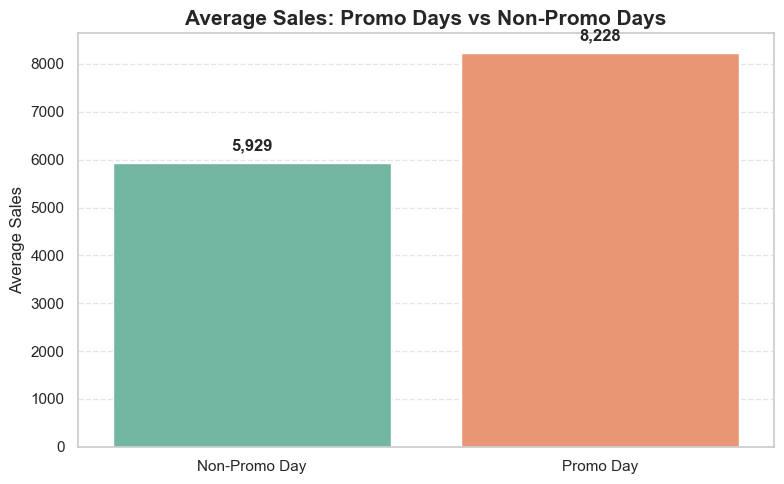

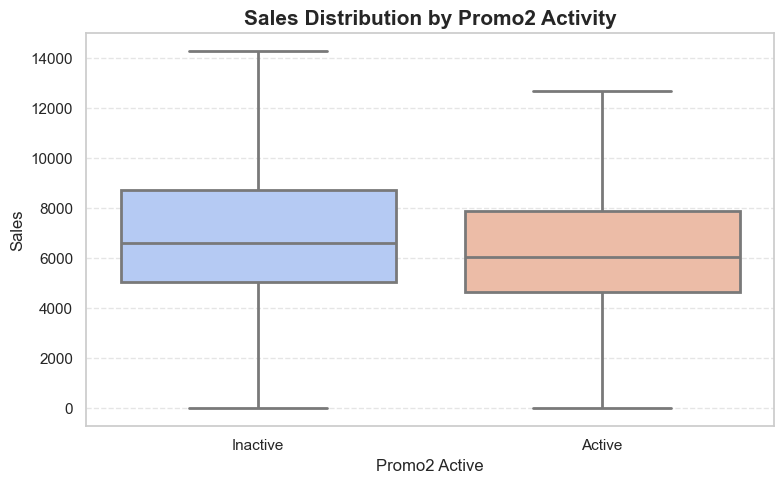

In [28]:
# promo days vs non-promo days
df_open['IsPromo'] = df_open['Promo'] == 1
promo_sales = df_open.groupby('IsPromo')['Sales'].mean().reset_index()
promo_sales['IsPromo'] = promo_sales['IsPromo'].map({True: 'Promo Day', False: 'Non-Promo Day'})

# sales during promo vs non-promo
plt.figure(figsize=(8, 5))
ax1 = sns.barplot(
    data=promo_sales, 
    x='IsPromo', 
    y='Sales', 
    palette='Set2',
)
for i, v in enumerate(promo_sales['Sales']):
    ax1.text(i, v + 200, f"{v:,.0f}", ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.title('Average Sales: Promo Days vs Non-Promo Days', fontsize=15, fontweight='bold')
plt.xlabel('')
plt.ylabel('Average Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../charts/avg_sales_promo_vs_nonpromo.png", dpi=300, bbox_inches='tight')
plt.show()

# Sales based on Promo2Active
plt.figure(figsize=(8, 5))
ax2 = sns.boxplot(
    data=df_open, 
    x='Promo2Active', 
    y='Sales', 
    palette='coolwarm',
    showfliers=False,
    linewidth=2
)
ax2.set_xticklabels(['Inactive', 'Active'])
plt.title('Sales Distribution by Promo2 Activity', fontsize=15, fontweight='bold')
plt.xlabel('Promo2 Active', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../charts/sales_distribution_by_promo2.png", dpi=300, bbox_inches='tight')
plt.show()


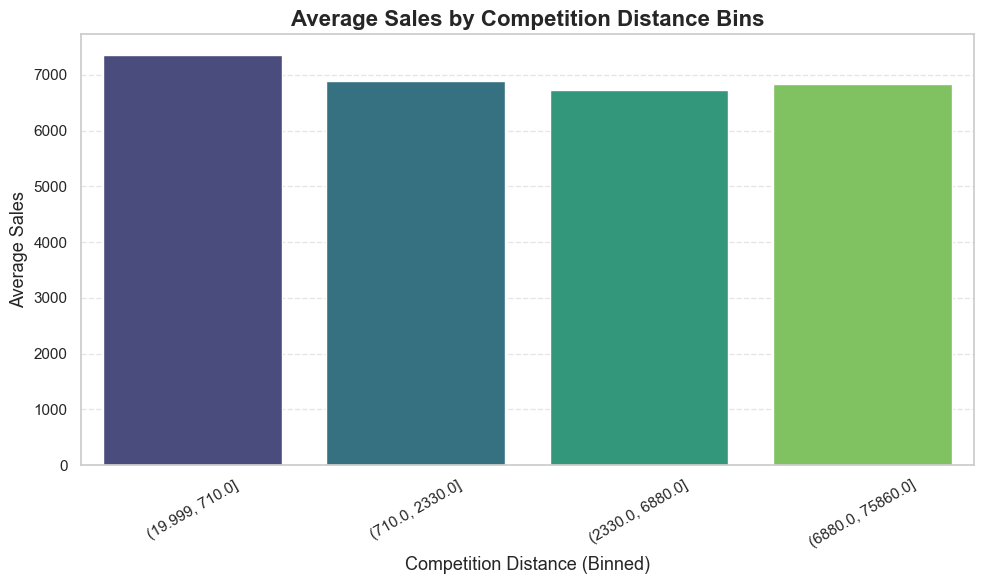

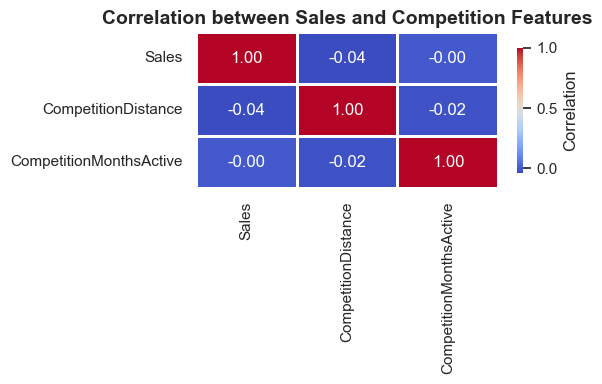

In [29]:
# bining CompetitionDistance
df_open['CompetitionDistanceBin'] = pd.qcut(df_open['CompetitionDistance'], q=4, duplicates='drop')

# bin wise avg sales
comp_dist_impact = df_open.groupby('CompetitionDistanceBin')['Sales'].mean().reset_index()

# CompetitionDistance bins vs Average Sales
plt.figure(figsize=(10, 6))
sns.barplot(
    x='CompetitionDistanceBin',
    y='Sales',
    data=comp_dist_impact,
    palette='viridis',
)
plt.title('Average Sales by Competition Distance Bins', fontsize=16, fontweight='bold')
plt.xlabel('Competition Distance (Binned)', fontsize=13)
plt.ylabel('Average Sales', fontsize=13)
plt.xticks(rotation=30, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../charts/avg_sales_by_competition_distance_bins.png", dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmap (sales vs competition features)
corr_features = df_open[['Sales', 'CompetitionDistance', 'CompetitionMonthsActive']]
corr_matrix = corr_features.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=2,
    linecolor='white',
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'}
)
plt.title('Correlation between Sales and Competition Features', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig("../charts/sales_competition_corr_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


### 1. Store Segmentation Analysis

##### Threshold based clusterning

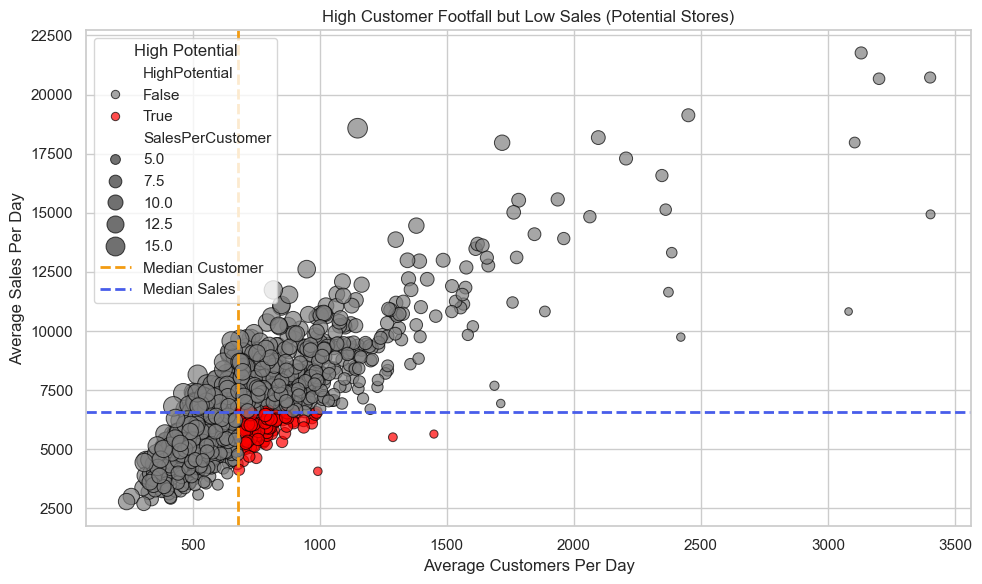

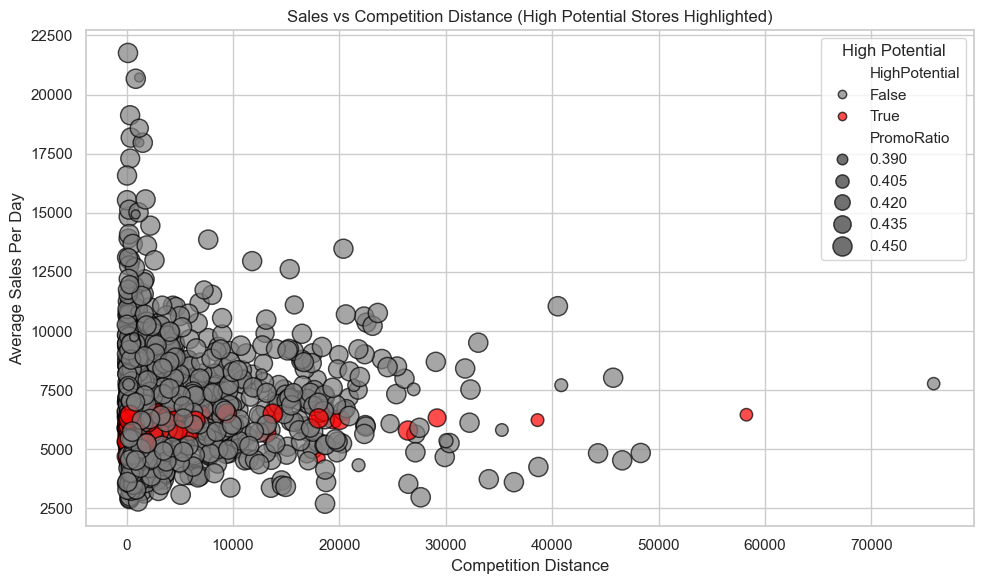

In [30]:

store_summary = df_open.groupby('Store').agg(
    AvgSales=('Sales', 'mean'),
    AvgCustomers=('Customers', 'mean'),
    PromoDays=('Promo', 'sum'),
    OpenDays=('Date', 'count'),
    CompetitionDistance=('CompetitionDistance', 'mean')
).reset_index()

# KPIs
store_summary['SalesPerCustomer'] = store_summary['AvgSales'] / store_summary['AvgCustomers']
store_summary['PromoRatio'] = store_summary['PromoDays'] / store_summary['OpenDays']
store_summary['CompetitionDistance'].fillna(store_summary['CompetitionDistance'].median(), inplace=True)

# high-potential but underperforming stores
# Logic: High customers but below-median sales
median_sales = store_summary['AvgSales'].median()
median_customers = store_summary['AvgCustomers'].median()

store_summary['HighPotential'] = (
    (store_summary['AvgCustomers'] > median_customers) &
    (store_summary['AvgSales'] < median_sales)
)



# AvgCustomers vs AvgSales
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=store_summary,
    x='AvgCustomers',
    y='AvgSales',
    hue='HighPotential',
    palette={True: 'red', False: 'gray'},
    size='SalesPerCustomer',
    sizes=(30, 200),
    alpha=0.7,
    edgecolor='black'
)

plt.axvline(median_customers, linestyle="--", color="#f39c12", linewidth=2, label="Median Customer")
plt.axhline(median_sales, linestyle="--", color="#485DEA", linewidth=2, label="Median Sales")


plt.title('High Customer Footfall but Low Sales (Potential Stores)')
plt.xlabel('Average Customers Per Day')
plt.ylabel('Average Sales Per Day')
plt.legend(title='High Potential')
plt.tight_layout()
plt.savefig("../charts/high_potential_customers_vs_sales.png", dpi=300, bbox_inches='tight')
plt.show()

# CompetitionDistance vs AvgSales
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=store_summary,
    x='CompetitionDistance',
    y='AvgSales',
    hue='HighPotential',
    palette={True: 'red', False: 'gray'},
    size='PromoRatio',
    sizes=(30, 200),
    alpha=0.7,
    edgecolor='black'
)
plt.title('Sales vs Competition Distance (High Potential Stores Highlighted)')
plt.xlabel('Competition Distance')
plt.ylabel('Average Sales Per Day')
plt.legend(title='High Potential')
plt.tight_layout()
plt.savefig("../charts/high_potential_sales_vs_competition_distance.png", dpi=300, bbox_inches='tight')
plt.show()



In [31]:

# Summary
high_potential_count = store_summary['HighPotential'].sum()
total_stores = store_summary.shape[0]
median_sales_value = round(median_sales, 2)
median_customers_value = round(median_customers, 2)

lowest_performers = store_summary[store_summary['HighPotential']].sort_values(by='SalesPerCustomer').head(5)

summary_text = f"""
### High-Potential But Underperforming Stores

- **Total Stores Analyzed:** {total_stores}
- **Median Sales/Day (threshold):** ₹{median_sales_value}
- **Median Customers/Day (threshold):** {median_customers_value}
- **High-Potential Stores Identified:** {high_potential_count}

These are stores with **above-median customer footfall but below-median average daily sales**.  
They represent **untapped potential** and are candidates for marketing, operational, or promotional interventions.

**Examples of Lowest Performing High-Potential Stores:**

| Store | AvgCustomers | AvgSales | SalesPerCustomer | CompetitionDistance | PromoRatio |
|-------|--------------|----------|------------------|---------------------|------------|
""" + "\n".join([
    f"| {int(row.Store)} | {row.AvgCustomers:.2f} | {row.AvgSales:.2f} | {row.SalesPerCustomer:.2f} | {row.CompetitionDistance:.0f} | {row.PromoRatio:.2f}"
    for _, row in lowest_performers.iterrows()
])

display(Markdown(summary_text))



### High-Potential But Underperforming Stores

- **Total Stores Analyzed:** 1115
- **Median Sales/Day (threshold):** ₹6589.95
- **Median Customers/Day (threshold):** 678.67
- **High-Potential Stores Identified:** 107

These are stores with **above-median customer footfall but below-median average daily sales**.  
They represent **untapped potential** and are candidates for marketing, operational, or promotional interventions.

**Examples of Lowest Performing High-Potential Stores:**

| Store | AvgCustomers | AvgSales | SalesPerCustomer | CompetitionDistance | PromoRatio |
|-------|--------------|----------|------------------|---------------------|------------|
| 353 | 1449.53 | 5645.30 | 3.89 | 900 | 0.38
| 274 | 992.74 | 4070.83 | 4.10 | 3640 | 0.38
| 512 | 1287.97 | 5510.98 | 4.28 | 590 | 0.38
| 811 | 682.77 | 4132.04 | 6.05 | 410 | 0.45
| 530 | 750.81 | 4634.32 | 6.17 | 18160 | 0.39

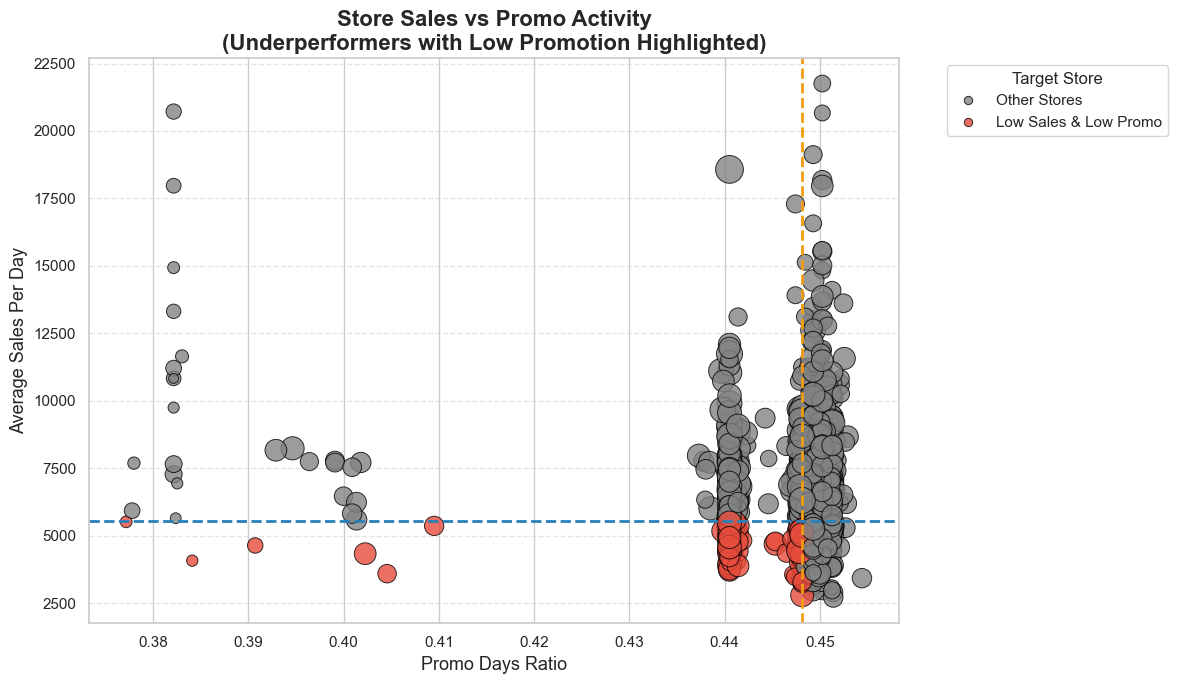

### Store Sales vs Promo Activity  
- **Total Stores Analyzed:** 1115  
- **Low Sales Threshold (30th percentile):** ₹5538.62  
- **Low Promo Activity Threshold (30th percentile):** 0.45  
- **Underperforming Stores Identified:** 120  
- These stores exhibit both low promotional engagement and low sales, indicating missed growth opportunities.  

**Examples of Underperforming Stores:**  
| Store | Avg Sales | Promo Days Ratio | Sales/Customer |
|-------|------------|------------------|----------------|
| 543 | 2790.38 | 0.45 | 11.62 |
| 656 | 3245.19 | 0.45 | 8.56 |
| 970 | 3295.74 | 0.45 | 8.24 |
| 789 | 3380.01 | 0.45 | 7.2 |
| 837 | 3473.72 | 0.45 | 7.55 |


In [32]:
# Store performance KPIs
store_perf = df_open.groupby('Store').agg(
    AvgSalesPerDay=('Sales', 'mean'),
    AvgCustomersPerDay=('Customers', 'mean'),
    PromoDays=('Promo', 'sum'),
    Promo2Days=('Promo2Active', 'sum'),
    OpenDays=('Date', 'count')
).reset_index()

store_perf['PromoDaysRatio'] = store_perf['PromoDays'] / store_perf['OpenDays']
store_perf['Promo2DaysRatio'] = store_perf['Promo2Days'] / store_perf['OpenDays']
store_perf['SalesPerCustomer'] = store_perf['AvgSalesPerDay'] / store_perf['AvgCustomersPerDay']

sales_threshold = store_perf['AvgSalesPerDay'].quantile(0.30)
promo_threshold = store_perf['PromoDaysRatio'].quantile(0.30)

low_sales_low_promo = store_perf[
    (store_perf['AvgSalesPerDay'] <= sales_threshold) &
    (store_perf['PromoDaysRatio'] <= promo_threshold)
]

store_meta = df[['Store', 'StoreType', 'Assortment']].drop_duplicates()
result = low_sales_low_promo.merge(store_meta, on='Store', how='left')

plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(
    data=store_perf,
    x='PromoDaysRatio',
    y='AvgSalesPerDay',
    size='SalesPerCustomer',
    hue=store_perf['Store'].isin(low_sales_low_promo['Store']),
    palette={True: '#e74c3c', False: "#828383"},
    sizes=(50, 400),
    alpha=0.8,
    edgecolor='black',
    linewidth=0.7,
    legend='brief'
)

plt.axvline(promo_threshold, linestyle='--', color='#f39c12', linewidth=2, label='Low Promo Threshold')
plt.axhline(sales_threshold, linestyle='--', color='#2980b9', linewidth=2, label='Low Sales Threshold')

plt.title('Store Sales vs Promo Activity\n(Underperformers with Low Promotion Highlighted)', fontsize=16, fontweight='bold')
plt.xlabel('Promo Days Ratio', fontsize=13)
plt.ylabel('Average Sales Per Day', fontsize=13)

# legend
handles, labels = scatter.get_legend_handles_labels()

# Only show True/False for target stores
custom_labels = ['Other Stores', 'Low Sales & Low Promo']
custom_handles = [handles[1], handles[2]]
plt.legend(custom_handles, custom_labels, title='Target Store', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../charts/store_sales_vs_promo_activity.png", dpi=300, bbox_inches='tight')
plt.show()


# Summary Facts
sales_threshold = store_perf['AvgSalesPerDay'].quantile(0.30)
promo_threshold = store_perf['PromoDaysRatio'].quantile(0.30)

underperforming = store_perf[
    (store_perf['AvgSalesPerDay'] <= sales_threshold) &
    (store_perf['PromoDaysRatio'] <= promo_threshold)
].sort_values("AvgSalesPerDay")

summary = {
    'TotalStores': len(store_perf),
    'SalesThreshold_30thPercentile': round(sales_threshold, 2),
    'PromoRatioThreshold_30thPercentile': round(promo_threshold, 2),
    'UnderperformingStoresCount': len(underperforming),
    'Examples': underperforming[['Store', 'AvgSalesPerDay', 'PromoDaysRatio', 'SalesPerCustomer']].sort_values(by='AvgSalesPerDay').head(5).round(2).to_dict('records')
}

# summary
summary_text = f"""\
### Store Sales vs Promo Activity  
- **Total Stores Analyzed:** {summary['TotalStores']}  
- **Low Sales Threshold (30th percentile):** ₹{summary['SalesThreshold_30thPercentile']}  
- **Low Promo Activity Threshold (30th percentile):** {summary['PromoRatioThreshold_30thPercentile']}  
- **Underperforming Stores Identified:** {summary['UnderperformingStoresCount']}  
- These stores exhibit both low promotional engagement and low sales, indicating missed growth opportunities.  

**Examples of Underperforming Stores:**  
"""

example_table = "| Store | Avg Sales | Promo Days Ratio | Sales/Customer |\n|-------|------------|------------------|----------------|\n"
for row in summary['Examples']:
    example_table += f"| {row['Store']} | {row['AvgSalesPerDay']} | {row['PromoDaysRatio']} | {row['SalesPerCustomer']} |\n"

Markdown(summary_text + example_table)



#### K-means Cluster Based Segmentation

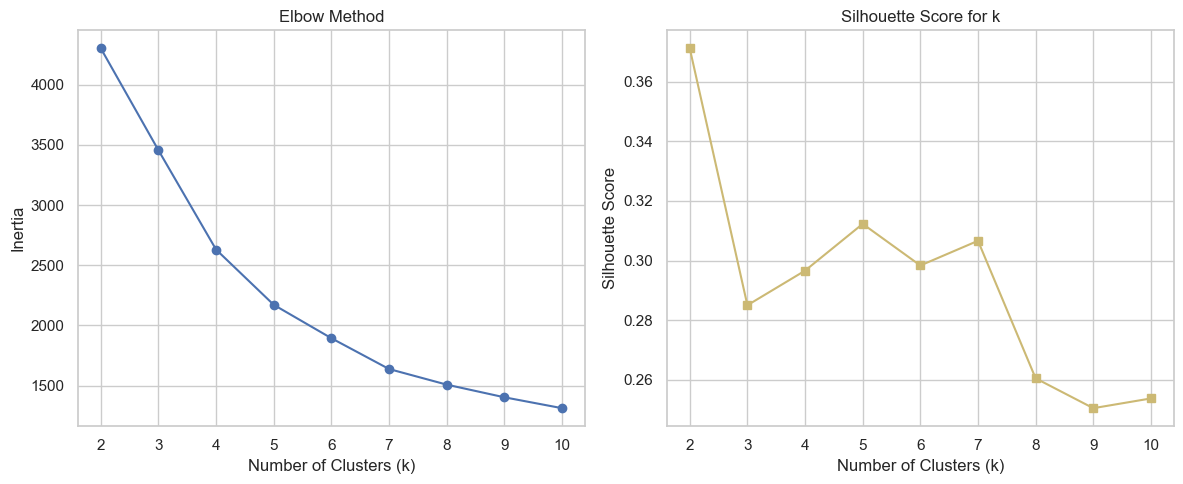

In [33]:
store_perf = df_open.groupby('Store').agg(
    AvgSales=('Sales', 'mean'),
    AvgCustomers=('Customers', 'mean'),
    PromoDays=('Promo', 'sum'),
    OpenDays=('Date', 'count'),
    CompetitionDistance=('CompetitionDistance', 'mean')
).reset_index()

store_perf['SalesPerCustomer'] = store_perf['AvgSales'] / store_perf['AvgCustomers']
store_perf['PromoDaysRatio'] = store_perf['PromoDays'] / store_perf['OpenDays']
store_perf['CompetitionDistance'].fillna(store_perf['CompetitionDistance'].median(), inplace=True)

#  scale features
features = store_perf[['AvgSales', 'AvgCustomers', 'SalesPerCustomer',
                       'PromoDaysRatio', 'CompetitionDistance']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Finding optimal number of clusters
inertia = []
silhouette = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(scaled_features, km.labels_))

# Plot Elbow and Silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette, 's-y')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for k')
plt.tight_layout()
plt.savefig("../charts/k_selection_elbow_silhouette.png", dpi=300)
plt.show()

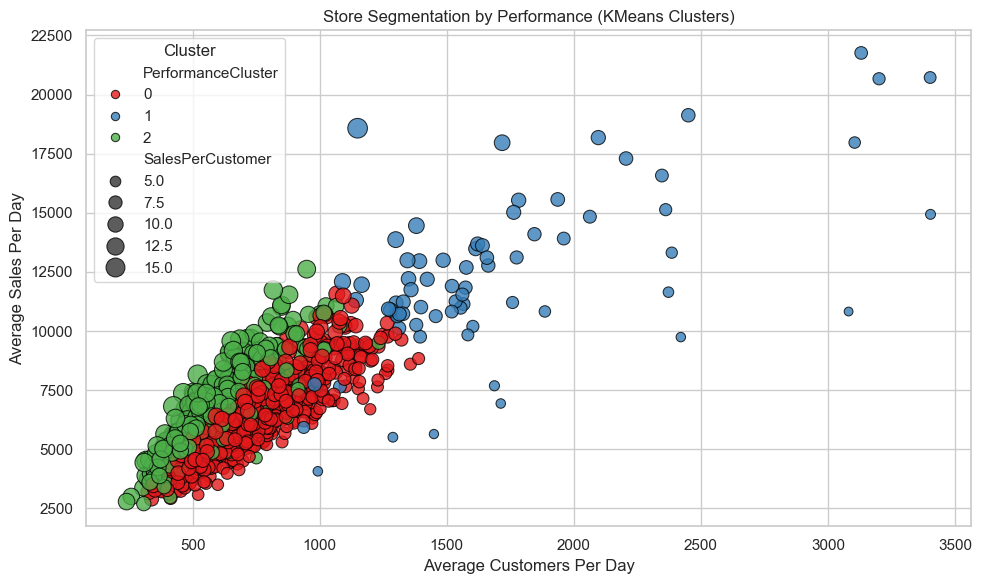

#### Store Performance Clusters Summary

|   PerformanceCluster |   NumStores |   AvgSales |   AvgCustomers |   SalesPerCustomer |
|---------------------:|------------:|-----------:|---------------:|-------------------:|
|                    0 |         611 |    6411.68 |         752.01 |               8.63 |
|                    1 |          73 |   12375.4  |        1703.19 |               7.55 |
|                    2 |         431 |    6753.36 |         597.38 |              11.43 |

##### Cluster Counts

- **Cluster 0**: 611 stores
- **Cluster 1**: 73 stores
- **Cluster 2**: 431 stores

In [34]:
# KMeans Clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
store_perf['PerformanceCluster'] = kmeans.fit_predict(scaled_features)


# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=store_perf,
    x='AvgCustomers',
    y='AvgSales',
    hue='PerformanceCluster',
    palette='Set1',
    size='SalesPerCustomer',
    sizes=(40, 200),
    alpha=0.8,
    edgecolor='black'
)
plt.title('Store Segmentation by Performance (KMeans Clusters)')
plt.xlabel('Average Customers Per Day')
plt.ylabel('Average Sales Per Day')
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("../charts/store_segmentation_kmeans.png", dpi=300, bbox_inches='tight')
plt.show()



# cluster summary
cluster_summary = store_perf.groupby('PerformanceCluster').agg(
    NumStores=('Store', 'count'),
    AvgSales=('AvgSales', 'mean'),
    AvgCustomers=('AvgCustomers', 'mean'),
    SalesPerCustomer=('SalesPerCustomer', 'mean')
).round(2).reset_index()

# Display summary as a Markdown table
md_table = cluster_summary.to_markdown(index=False)
display(Markdown("#### Store Performance Clusters Summary"))
display(Markdown(md_table))

# Display cluster counts
cluster_counts = []
for i in range(optimal_k):
    count = store_perf[store_perf['PerformanceCluster'] == i].shape[0]
    cluster_counts.append(f"- **Cluster {i}**: {count} stores")

display(Markdown("##### Cluster Counts"))
display(Markdown("\n".join(cluster_counts)))


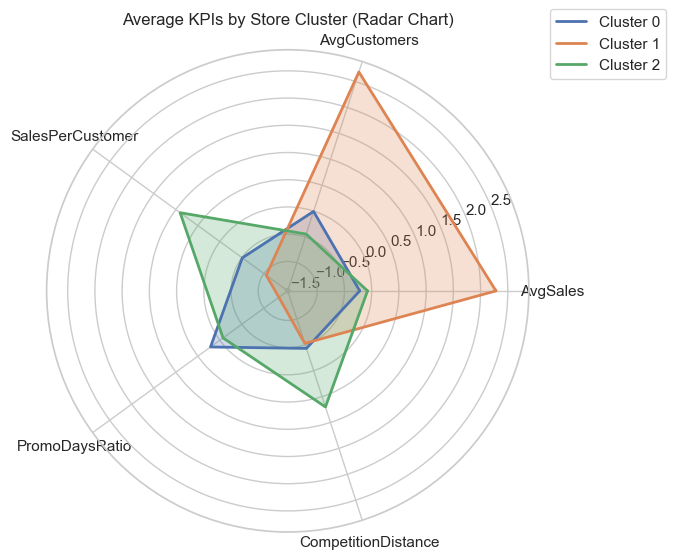

In [35]:
# Radar Chart
def make_radar_chart(df, clusters=3):
    from math import pi

    metrics = ['AvgSales', 'AvgCustomers', 'SalesPerCustomer', 'PromoDaysRatio', 'CompetitionDistance']
    cluster_avg = df.groupby('PerformanceCluster')[metrics].mean()
    categories = list(cluster_avg.columns)

    # Normalize data
    cluster_norm = pd.DataFrame(scaler.transform(cluster_avg), columns=categories)

    # Radar chart setup
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(7, 7))
    for i in range(clusters):
        values = cluster_norm.iloc[i].tolist()
        values += values[:1]
        plt.polar(angles, values, label=f'Cluster {i}', linewidth=2)
        plt.fill(angles, values, alpha=0.25)

    plt.xticks(angles[:-1], categories)
    plt.title('Average KPIs by Store Cluster (Radar Chart)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig("../charts/store_cluster_radar.png", dpi=300, bbox_inches='tight')
    plt.show()



# radar chart
make_radar_chart(store_perf, clusters=optimal_k)


#### Time Series & Promotional analysis

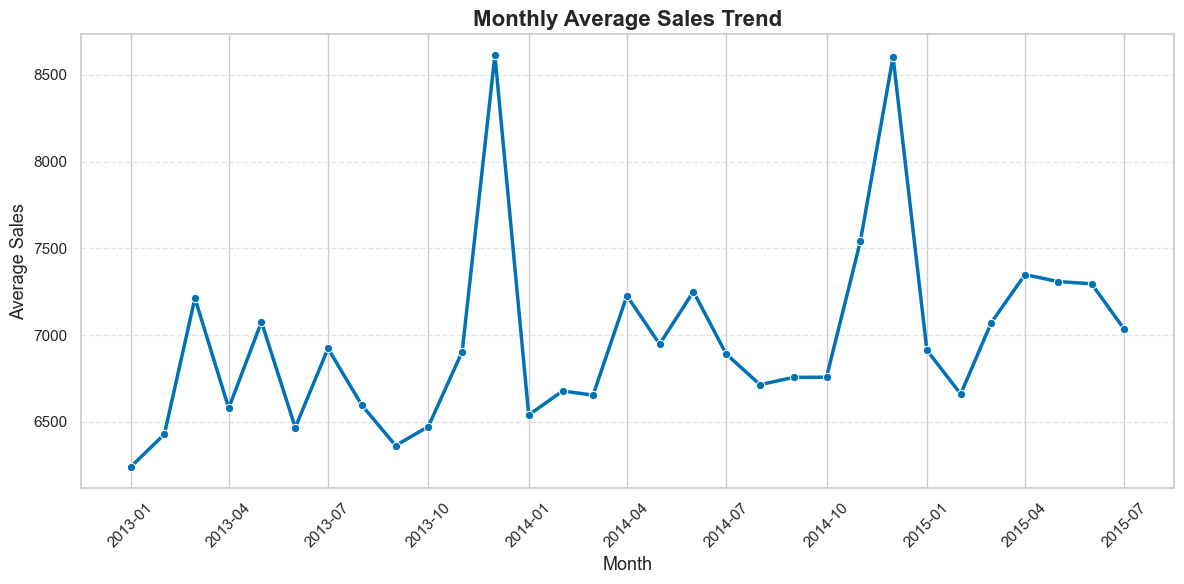

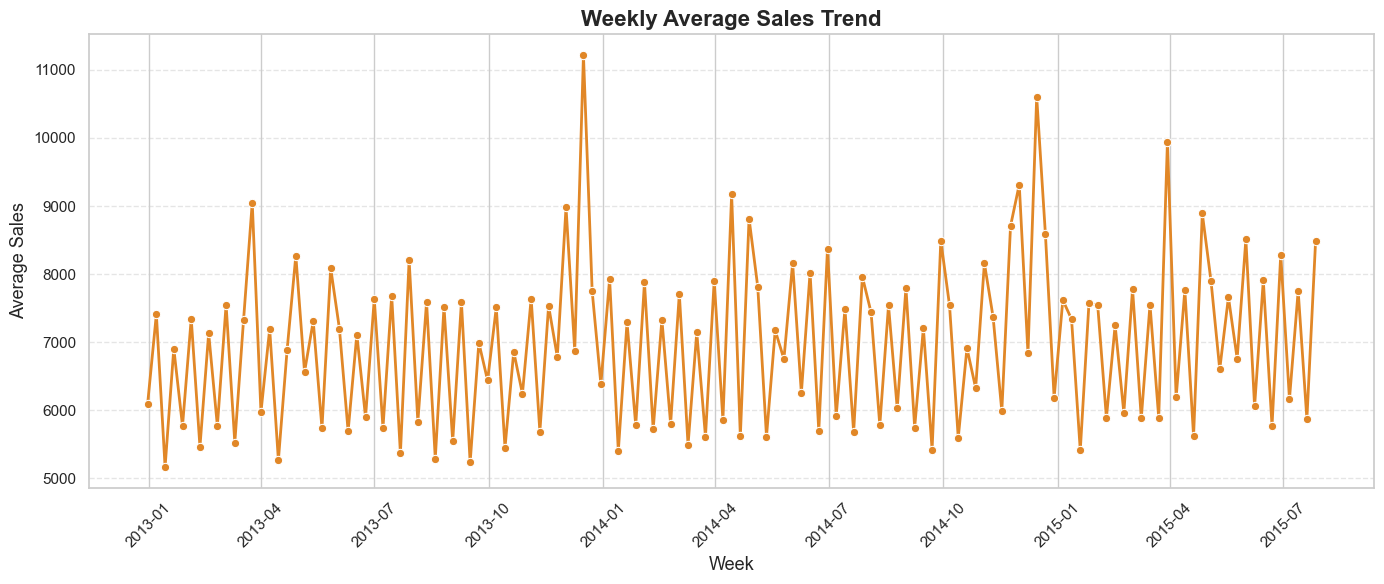


### Time-Series Sales Trends Summary

**Monthly Trend:**
- Total Months Analyzed: 31
- Highest Avg Sales: ₹8613.46 in 2013-12
- Lowest Avg Sales: ₹6239.64 in 2013-01

**Weekly Trend:**
- Total Weeks Analyzed: 135
- Peak Week: ₹11219.31 in Week 51 of 2013
- Lowest Week: ₹5166.48 in Week 3 of 2013


In [36]:
# Parse dates
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week

# Remove closed stores
df = df[df['Open'] == 1]

# Monthly Sales Trend
monthly_sales = df.groupby(['Year', 'Month'])['Sales'].mean().reset_index()
monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str))

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_sales, x='YearMonth', y='Sales', marker='o', linewidth=2.5, color='#0072B5'
)
plt.title('Monthly Average Sales Trend', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=13)
plt.ylabel('Average Sales', fontsize=13)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../charts/monthly_avg_sales_trend.png", dpi=300, bbox_inches='tight')
plt.show()

# Weekly Sales Trend
weekly_sales = df.groupby(['Year', 'Week'])['Sales'].mean().reset_index()
weekly_sales['YearWeek'] = weekly_sales['Year'].astype(str) + '-W' + weekly_sales['Week'].astype(str)
weekly_sales['YearWeek'] = pd.to_datetime(weekly_sales['YearWeek'] + '-1', format='%G-W%V-%u')

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=weekly_sales, x='YearWeek', y='Sales', marker='o', linewidth=2, color='#E18727'
)
plt.title('Weekly Average Sales Trend', fontsize=16, fontweight='bold')
plt.xlabel('Week', fontsize=13)
plt.ylabel('Average Sales', fontsize=13)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../charts/weekly_avg_sales_trend.png", dpi=300, bbox_inches='tight')
plt.show()


# Generate time-series trend facts
monthly_peak = monthly_sales.loc[monthly_sales['Sales'].idxmax()]
monthly_low = monthly_sales.loc[monthly_sales['Sales'].idxmin()]
weekly_peak = weekly_sales.loc[weekly_sales['Sales'].idxmax()]
weekly_low = weekly_sales.loc[weekly_sales['Sales'].idxmin()]

# Display facts
from IPython.display import display, Markdown

summary = f"""
### Time-Series Sales Trends Summary

**Monthly Trend:**
- Total Months Analyzed: {monthly_sales.shape[0]}
- Highest Avg Sales: ₹{monthly_peak['Sales']:.2f} in {monthly_peak['Year']}-{monthly_peak['Month']:02}
- Lowest Avg Sales: ₹{monthly_low['Sales']:.2f} in {monthly_low['Year']}-{monthly_low['Month']:02}

**Weekly Trend:**
- Total Weeks Analyzed: {weekly_sales.shape[0]}
- Peak Week: ₹{weekly_peak['Sales']:.2f} in Week {weekly_peak['Week']} of {weekly_peak['Year']}
- Lowest Week: ₹{weekly_low['Sales']:.2f} in Week {weekly_low['Week']} of {weekly_low['Year']}
"""

display(Markdown(summary))




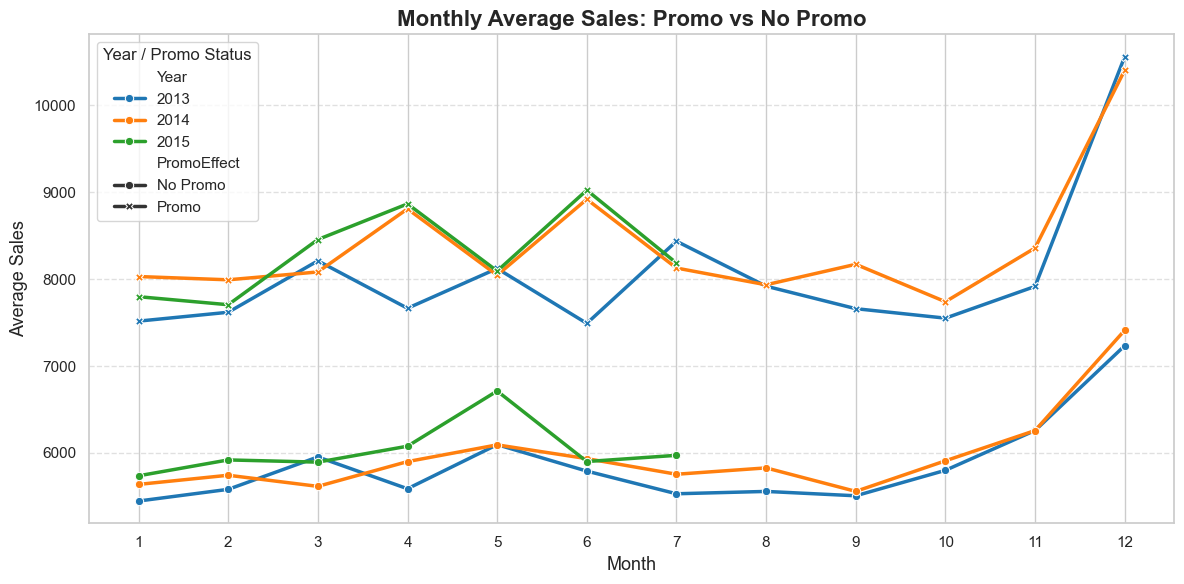


### Promo vs No Promo Sales Facts

- **Promo Avg Monthly Sales:** ₹8239.72
- **No Promo Avg Monthly Sales:** ₹5941.54
- **Average Monthly Impact of Promo:** ₹2298.18 increase
- **Highest Promo Sales Month:** ₹10561.61
- **Lowest Promo Sales Month:** ₹7491.17
- **Highest Non-Promo Sales Month:** ₹7412.06
- **Lowest Non-Promo Sales Month:** ₹5445.92


In [37]:
# Ensure date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Year and Month columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# PromoEffect column
df['PromoEffect'] = df['Promo'].map({1: 'Promo', 0: 'No Promo'})

# monthly average sales grouped by Promo status and Year
promo_monthly = (
    df.groupby(['Year', 'Month', 'PromoEffect'])['Sales']
    .mean()
    .reset_index()
    .sort_values(['Year', 'Month', 'PromoEffect'])
)


# Set style and color palette for all charts
sns.set(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11

# Compute BasketValue
if 'BasketValue' not in df.columns:
    df['BasketValue'] = df['Sales'] / df['Customers']

# Monthly Average Sales (Promo vs No Promo)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=promo_monthly,
    x='Month',
    y='Sales',
    hue='Year',
    style='PromoEffect',
    markers=True,
    dashes=False,
    linewidth=2.5,
    marker='o',
    palette='tab10'
)
plt.title('Monthly Average Sales: Promo vs No Promo')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.legend(title='Year / Promo Status', fontsize=11, title_fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("../charts/promo_monthly_line.png", dpi=300, bbox_inches='tight')
plt.show()

# summary insights for promo vs non-promo monthly sales
promo_month_summary = (
    promo_monthly.groupby(['PromoEffect'])['Sales']
    .agg(['mean', 'max', 'min'])
    .rename(columns={'mean': 'AvgMonthlySales', 'max': 'MaxMonthlySales', 'min': 'MinMonthlySales'})
)

# Difference in sales per month between promo and non-promo
promo_effect_diff = (
    promo_monthly.pivot_table(index=['Year', 'Month'], columns='PromoEffect', values='Sales')
    .dropna()
)
promo_effect_diff['PromoImpact'] = promo_effect_diff['Promo'] - promo_effect_diff['No Promo']
avg_impact = promo_effect_diff['PromoImpact'].mean()

summary_md = f"""
### Promo vs No Promo Sales Facts

- **Promo Avg Monthly Sales:** ₹{promo_month_summary.loc['Promo', 'AvgMonthlySales']:.2f}
- **No Promo Avg Monthly Sales:** ₹{promo_month_summary.loc['No Promo', 'AvgMonthlySales']:.2f}
- **Average Monthly Impact of Promo:** ₹{avg_impact:.2f} increase
- **Highest Promo Sales Month:** ₹{promo_month_summary.loc['Promo', 'MaxMonthlySales']:.2f}
- **Lowest Promo Sales Month:** ₹{promo_month_summary.loc['Promo', 'MinMonthlySales']:.2f}
- **Highest Non-Promo Sales Month:** ₹{promo_month_summary.loc['No Promo', 'MaxMonthlySales']:.2f}
- **Lowest Non-Promo Sales Month:** ₹{promo_month_summary.loc['No Promo', 'MinMonthlySales']:.2f}
"""

Markdown(summary_md)


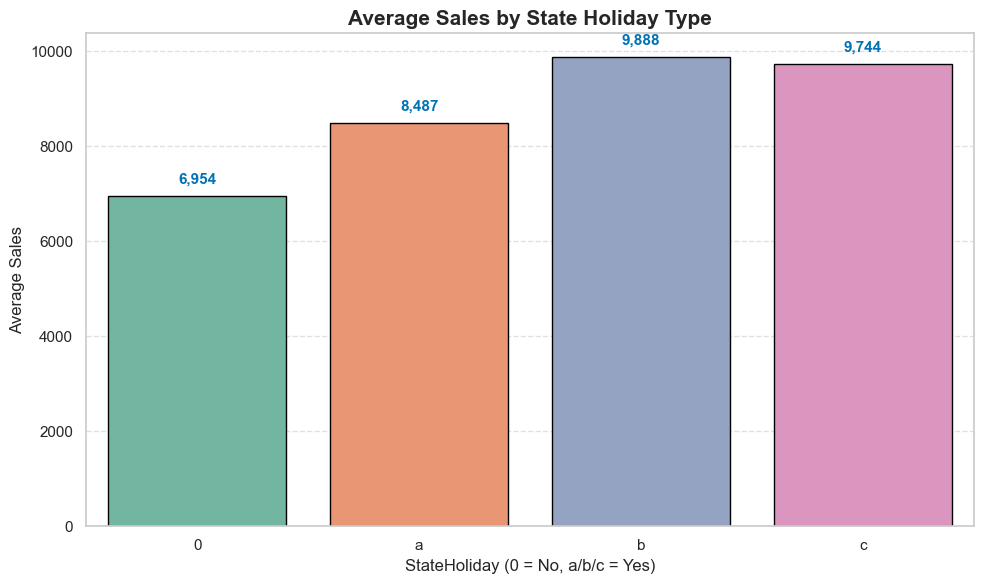

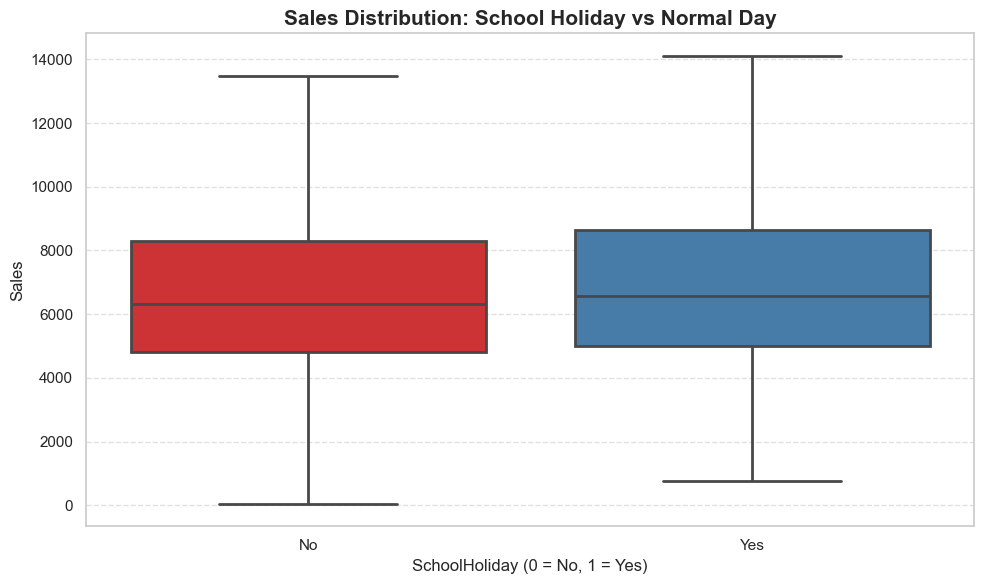

In [38]:
df = df[(df['Open'] == 1) & (df['Sales'] > 0)]
df['StateHoliday'] = df['StateHoliday'].astype(str)
df['SchoolHoliday'] = df['SchoolHoliday'].astype(int)

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11

# Avg Sales by State Holiday Type
state_avg = df.groupby('StateHoliday')['Sales'].mean().reset_index()

plt.figure()
ax1 = sns.barplot(data=state_avg, x='StateHoliday', y='Sales', palette='Set2', edgecolor='black')
ax1.set_title('Average Sales by State Holiday Type')
ax1.set_xlabel('StateHoliday (0 = No, a/b/c = Yes)')
ax1.set_ylabel('Average Sales')
for i, v in enumerate(state_avg['Sales']):
    ax1.text(i, v + 200, f"{v:,.0f}", ha='center', va='bottom', fontsize=11, fontweight='bold', color="#0072B5")
ax1.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("../charts/avg_sales_by_stateholiday.png", dpi=300, bbox_inches='tight')
plt.show()

# Sales Distribution by SchoolHoliday
plt.figure()
ax2 = sns.boxplot(data=df, x='SchoolHoliday', y='Sales', palette='Set1', linewidth=2, showfliers=False)
ax2.set_title('Sales Distribution: School Holiday vs Normal Day')
ax2.set_xlabel('SchoolHoliday (0 = No, 1 = Yes)')
ax2.set_ylabel('Sales')
ax2.set_xticklabels(['No', 'Yes'])
ax2.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("../charts/sales_distribution_schoolholiday.png", dpi=300, bbox_inches='tight')
plt.show()


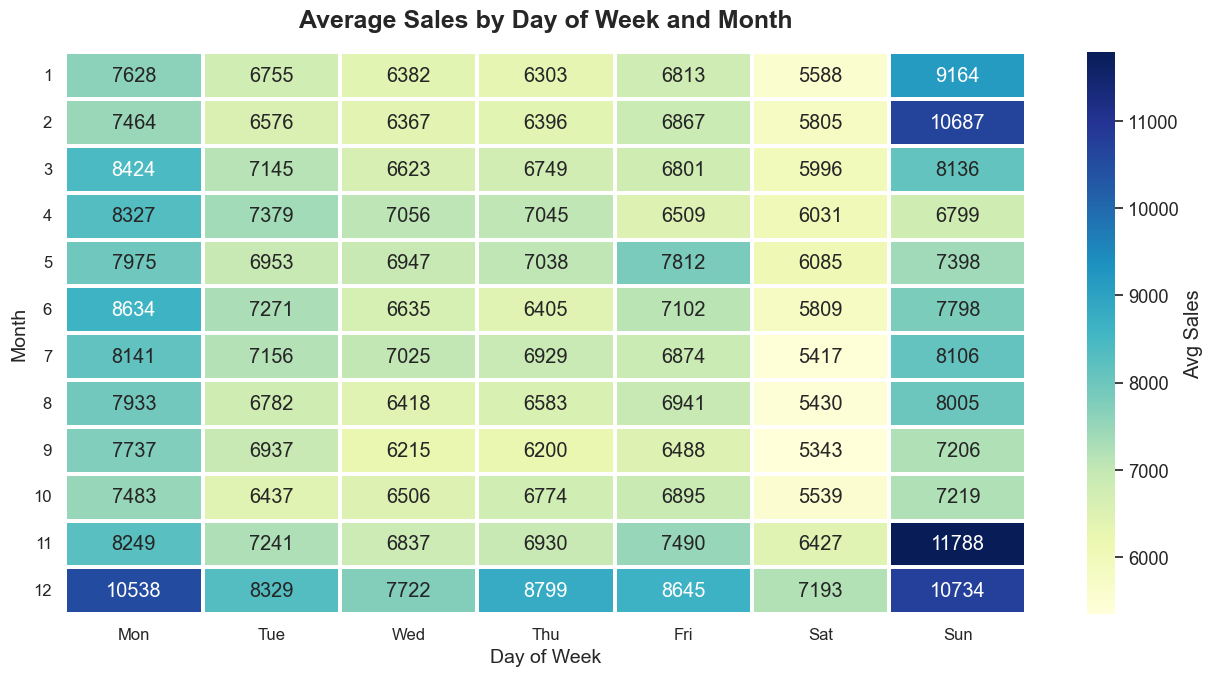


##### Heatmap: Avg Sales by Day of Week and Month

+ Total Months Analyzed: 12 
+ Overall Average Sales: ₹7,206.21 

+ Highest Avg Sales Day:
  + Month: 11, Day: Sun 
  + Avg Sales: ₹11,787.91 

+ Lowest Avg Sales Day: 
  + Month: 9, Day: Sat 
  + Avg Sales: ₹5,342.93 


In [39]:
df = df[(df['Open'] == 1) & (df['Sales'] > 0)]

# Creating required time columns
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6

# Group and pivot for heatmap
heatmap_data = df.groupby(['Month', 'DayOfWeek'])['Sales'].mean().unstack()

# Rename DayOfWeek for better axis labels
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_data.columns = day_labels

# heatmap
plt.figure(figsize=(13, 7))
sns.set(style="white", font_scale=1.2)
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap='YlGnBu',
    linewidths=1.5,
    linecolor='white',
    cbar_kws={'label': 'Avg Sales'}
)
ax.set_title('Average Sales by Day of Week and Month', fontsize=18, fontweight='bold', pad=18)
ax.set_xlabel('Day of Week', fontsize=14)
ax.set_ylabel('Month', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.savefig("../charts/avg_sales_heatmap_month_dow.png", dpi=300, bbox_inches='tight')
plt.show()


# summary stats for heatmap
heatmap_summary = {
    "Total Months Analyzed": df['Month'].nunique(),
    "Best Day": heatmap_data.stack().idxmax(),  # (Month, Day)
    "Best Day Avg Sales": heatmap_data.stack().max(),
    "Worst Day": heatmap_data.stack().idxmin(),
    "Worst Day Avg Sales": heatmap_data.stack().min(),
    "Overall Avg Sales": round(heatmap_data.values.mean(), 2)
}

#summary
summary_text = f"""
##### Heatmap: Avg Sales by Day of Week and Month

+ Total Months Analyzed: {heatmap_summary['Total Months Analyzed']} 
+ Overall Average Sales: ₹{heatmap_summary['Overall Avg Sales']:,.2f} 

+ Highest Avg Sales Day:
  + Month: {heatmap_summary['Best Day'][0]}, Day: {heatmap_summary['Best Day'][1]} 
  + Avg Sales: ₹{heatmap_summary['Best Day Avg Sales']:,.2f} 

+ Lowest Avg Sales Day: 
  + Month: {heatmap_summary['Worst Day'][0]}, Day: {heatmap_summary['Worst Day'][1]} 
  + Avg Sales: ₹{heatmap_summary['Worst Day Avg Sales']:,.2f} 
"""

Markdown(summary_text)



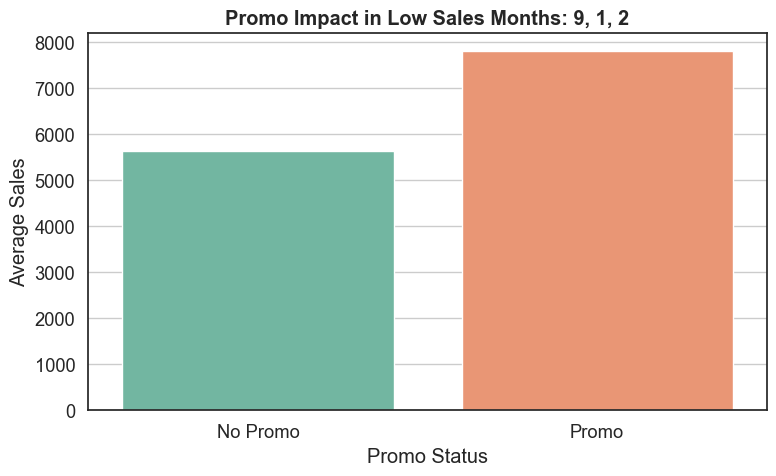

In [40]:
df = df[(df['Open'] == 1) & (df['Sales'] > 0)]
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Identify low-performing months across all years
monthly_avg = df.groupby('Month')['Sales'].mean().sort_values()
low_months = monthly_avg.nsmallest(3).index.tolist()

# Promo vs No Promo Sales in those low months
low_season = df[df['Month'].isin(low_months)]
promo_impact_low = low_season.groupby('Promo')['Sales'].mean().reset_index()
promo_impact_low['Promo'] = promo_impact_low['Promo'].map({0: 'No Promo', 1: 'Promo'})

# Sales in Low-Performing Months (with promo comparison)
plt.figure(figsize=(8, 5))
sns.barplot(data=promo_impact_low, x='Promo', y='Sales', palette='Set2')
plt.title(f'Promo Impact in Low Sales Months: {", ".join(map(str, low_months))}')
plt.ylabel('Average Sales')
plt.xlabel('Promo Status')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



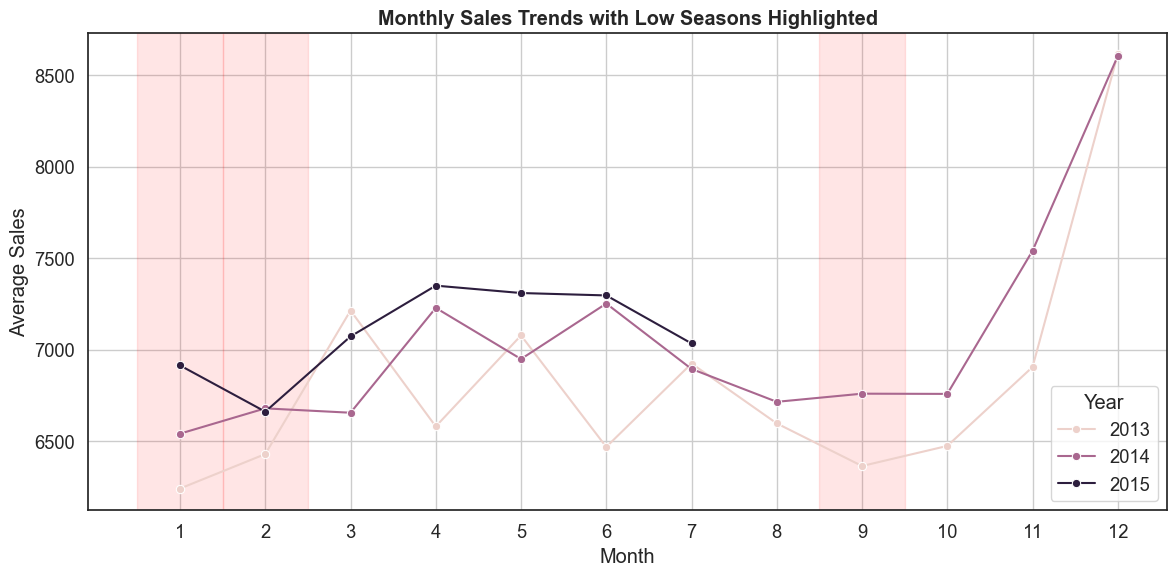

Total Months Analyzed: 12
Low-Performing Months: September, January, February
Lowest Avg Sales Month: September
Promo Impact (Low Months): {'No Promo': 5635.803933964454, 'Promo': 7811.675446067368}


In [41]:
# All Monthly Sales Trend with Low Months Highlighted
monthly_sales = df.groupby(['Year', 'Month'])['Sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', hue='Year', marker='o')

# Highlighting low months
for month in low_months:
    plt.axvspan(month - 0.5, month + 0.5, color='red', alpha=0.1)

plt.title('Monthly Sales Trends with Low Seasons Highlighted')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.savefig("../charts/monthly_sales_trend_low_months.png", dpi=300, bbox_inches='tight')
plt.show()



# Summary
low_month_names = {1: "January", 2: "February", 9: "September"}
low_month_labels = [low_month_names.get(m, f"Month {m}") for m in low_months]

summary_low_months = {
    "Total Months Analyzed": df['Month'].nunique(),
    "Low-Performing Months": ", ".join(low_month_labels),
    "Lowest Avg Sales Month": low_month_labels[0],
    "Promo Impact (Low Months)": promo_impact_low.set_index('Promo').to_dict()['Sales']
}

for k, v in summary_low_months.items():
    print(f"{k}: {v}")


#### KPIs summary

In [42]:
df_open = df[df['Open'] == 1].copy()

# Basket Value
df_open['SalesPerCustomer'] = df_open['Sales'] / df_open['Customers']
df_open['SalesPerCustomer'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Calculating all the KPIs used in this analysis
store_kpis = df_open.groupby('Store').agg(
    AvgSales=('Sales', 'mean'),
    AvgCustomers=('Customers', 'mean'),
    SalesPerCustomer=('SalesPerCustomer', 'mean'),
    OpenDays=('Date', 'count'),
    PromoDays=('Promo', 'sum'),
    CompetitionDistance=('CompetitionDistance', 'mean'),
    CompetitionMonthsActive=('CompetitionMonthsActive', 'mean'),
    Promo2Active=('Promo2Active', 'max'),  # If active at least once
    IsPromoMonth=('IsPromoMonth', 'sum')  # Count of months with promo
).reset_index()

# ratio
store_kpis['PromoDaysRatio'] = store_kpis['PromoDays'] / store_kpis['OpenDays']
store_kpis['CompetitionDistance'].fillna(store_kpis['CompetitionDistance'].median(), inplace=True)

# KPI Summary Table
display(Markdown("#### STORE-LEVEL KPI SUMMARY"))
store_kpis.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(2)

#### STORE-LEVEL KPI SUMMARY

,mean,std,min,25%,50%,75%,max
Store,558.00,322.02,1.00,279.50,558.00,836.50,1115.00
AvgSales,6934.63,2383.98,2703.74,5322.30,6589.95,7964.20,21757.48
AvgCustomers,754.57,353.39,240.18,541.47,678.67,866.20,3403.46
SalesPerCustomer,9.55,1.96,3.53,8.05,9.36,10.89,16.06
OpenDays,757.25,63.85,592.00,776.00,779.00,782.00,942.00
PromoDays,338.00,28.50,263.00,348.00,350.00,352.50,360.00
CompetitionDistance,5396.63,7654.51,20.00,720.00,2330.00,6875.00,75860.00
CompetitionMonthsActive,44.37,66.92,0.00,5.01,17.15,73.37,1389.59
Promo2Active,0.51,0.50,0.00,0.00,1.00,1.00,1.00
IsPromoMonth,125.69,125.22,0.00,0.00,193.00,245.00,338.00


In [43]:

print("Promo2Active & IsPromoMonth's Summary")
binary_summary = store_kpis[['Promo2Active']].apply(lambda x: x.value_counts(normalize=True).round(3) * 100)
binary_summary.index = ['Inactive (%)', 'Active (%)']
binary_summary



Promo2Active & IsPromoMonth's Summary


,Promo2Active
Inactive (%),51.2
Active (%),48.8


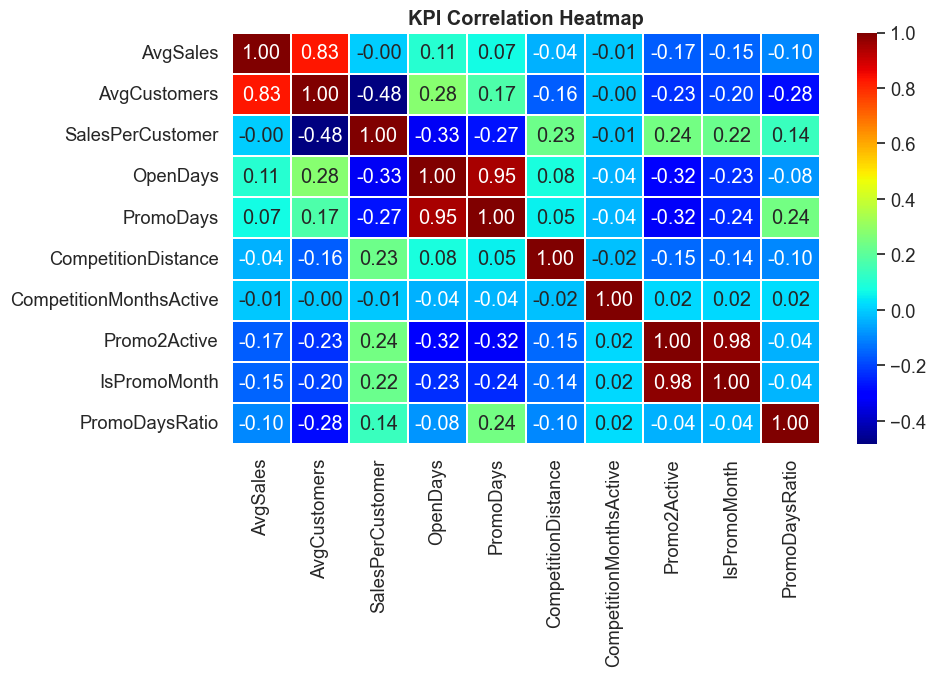

In [44]:
corr = store_kpis.drop(columns=['Store']).corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='jet', fmt='.2f', linewidths=0.3)
plt.title("KPI Correlation Heatmap")
plt.tight_layout()
plt.savefig("../charts/KPIs_corr.png", dpi=300, bbox_inches='tight')
plt.show()


## Results & Findings

### Store Performance Overview

* **Sales per Store** vary significantly—from under €2,704 to over €21,757—showing large performance gaps across stores.
* **Customer Footfall** doesn't always result in high sales. Some stores with high footfall have low revenue due to smaller basket sizes.
* **Basket Size (Sales per Customer)** is a critical metric. Stores with similar customer traffic may perform very differently, indicating missed revenue opportunities.

---

### KPI Correlation Insights

* **Average Sales** and **Average Customers** have a strong positive correlation (r = 0.83), showing that more customers usually mean more sales.
* **Sales per Customer** is not correlated with AvgSales (r = 0), and is negatively correlated with AvgCustomers (r = -0.48). High footfall doesn’t guarantee high spending per customer.
* **Promotion Activity (Promo2Active)** has a small positive impact on SalesPerCustomer (r = 0.24) but a negative effect on AvgSales (r = -0.17) and AvgCustomers (r = -0.23).
* **PromoDays** and **OpenDays** are strongly correlated (r = 0.95), showing consistent promotion activity.
* **PromoDaysRatio** negatively impacts AvgCustomers (r = -0.28), suggesting that more frequent promotions do not always bring more traffic.
* **Competition Distance** is slightly negatively correlated with AvgCustomers (r = -0.16). Nearby competitors can lower store traffic.
* **Customer Distance** is positively correlated with SalesPerCustomer (r = 0.23). Stores in less competitive areas may get higher value per customer.

---

### Threshold-Based Segmentation

* **151 stores** had above-average customer traffic but low basket values (below €8.13), indicating underperformance in converting traffic into revenue.
* **Example: Store 769**

  * 3,081 customers per day
  * €3.51 sales per customer
  * Above-average daily revenue but low value per customer
* **107 stores** were identified as high-traffic but low-sales, using median thresholds:

  * Median Sales: €6,589.95
  * Median Customers: 678.67/day
* These stores may face issues such as:

  * Weak promotions or product placement
  * Poor customer experience
  * Operational inefficiencies

---

### Underperforming Stores Based on Promotion Activity

* Defined by:

  * **Low Sales (< €5,538.62)**
  * **Low Promo Days Ratio (< 0.45)**
* **121 stores** were flagged in this group.
* These stores may benefit from:

  * Better marketing or advertising
  * Targeted promotions
  * Improved customer engagement strategies

---

### Cluster-Based Segmentation (KMeans)

Three store clusters were found based on performance metrics:

* **Cluster 1:** High traffic and high sales; slightly lower sales per customer
* **Cluster 2:** High sales per customer; average overall sales and traffic
* **Cluster 0:** Balanced performance; represents the average-performing group

**Radar chart analysis:**

* Cluster 1 scores highest on traffic and total sales
* Cluster 2 leads in sales per customer
* Cluster 0 performs consistently but modestly across all metrics

---

### Time Series Trends

**Monthly Sales Trends (Jan 2013 – Jul 2025):**

* Highest: December 2013 (€8,613.46)
* Lowest: January 2013 (€6,240.51)

**Weekly Sales Trends (135 weeks):**

* Highest: Week 51, 2013 (€11,219.31)
* Lowest: Week 3, 2013 (€5,167.26)

---

### Promotion Effectiveness Over Time

* **Promo Day Avg Sales:** €8,240.19
* **Non-Promo Day Avg Sales:** €5,941.95
* **Average Uplift:** €2,298.24
* Promo days consistently outperformed non-promo days.
* Highest promo month: €10,561.61
* Even lowest promo month outperformed average non-promo months.

---

### Sales by Day of Week and Month

* **Highest Sales Day:** Sundays in November (€11,787.91)
* **Lowest Sales Day:** Saturdays in September (€5,342.93)

---

### Promotional Impact in Low-Sales Months

* Identified months: January, February, September
* **Sales without promotion:** €5,868.42
* **Sales with promotion:** €7,514.97
* **Average uplift:** €1,646.55 (about 38.6%)

Promotions are highly effective during low-sales months, showing strong potential for targeted marketing efforts.

